# **El Impacto De Las Condiciones Ambientales En La Calidad Del Agua Del Río De La Plata**



###  Mentoría 7 | Trabajo Práctico Complementario – Grupo 2
- Benitez, Macarena
- Castro Luna, Eduardo
- Gutierrez, Federico
- Wolowski, Mauro

Bibliografia :
-  Intendencia de Montevideo. (2022). Estudio de la calidad de agua del Río de la Plata: Sistema Oeste, agosto–diciembre 2021. Montevideo: Servicio de Evaluación de la Calidad y Control Ambiental. Recuperado de https://montevideo.gub.uy/sites/default/files/biblioteca/informeestudiodelacalidadaguadelriodelaplatasistemaoesteagosto-diciembre2021.pdf

- Intendencia de Montevideo. (2015). Estudio de línea de base del Río de la Plata [Informe técnico]. Montevideo: Intendencia de Montevideo, Departamento de Calidad Ambiental. Recuperado de
 https://www.montevideo.gub.uy/sites/default/files/biblioteca/informeestudiodelineadebaseriodelaplata2015final.pdf

###Libreria

In [1]:
#Librerias

import pandas as pd
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import ee
import geemap
import datetime
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from datetime import datetime
from folium import Map, Marker, LayerControl, TileLayer, features
from branca.element import MacroElement
from jinja2 import Template
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from datetime import timedelta
from tqdm.notebook import tqdm


#### Dataset

In [69]:
# Cargar el dataset

url = "https://raw.githubusercontent.com/MaricelSantos/Mentoria--Diplodatos-2025/main/Conexiones_Transparentes.csv"
df = pd.read_csv(url)


# Variable objetivo

Se definió la variable clorofila_a_ug_l como objetivo del modelo, por ser un indicador ambiental clave vinculado a la calidad del agua. Esta variable es continua.  

**La medición de la clorofila en el agua es importante para evaluar la calidad del agua y la salud del ecosistema, ya que niveles altos de clorofila pueden indicar eutrofización y desequilibrios ecológicos.**

Otras variables complementarias fue campaña, fecha, turbidez del agua, temperatura

## *Resumen de descripción de la variable clorofila_a_ug_l*

In [ ]:
# Filtrar solo registros con clorofila válida, pero conservar todas las columnas
df_validos = df[df['clorofila_a_ug_l'].notna()].copy()

In [ ]:
df_validos['clorofila'] = pd.to_numeric(df_validos['clorofila_a_ug_l'], errors='coerce')

In [5]:
# === 1) Trabajar sobre el texto original (antes de convertir a número) ===
s_raw = df['clorofila_a_ug_l'].astype('string')  # preserva NA de pandas

def _normalize(x: pd.Series) -> pd.Series:
    y = x.fillna('')
    # quitar tildes
    y = y.apply(lambda t: unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('ascii'))
    # minúscula, trim y colapsar espacios
    y = y.str.lower().str.strip().str.replace(r'\s+', ' ', regex=True)
    return y

s_norm = _normalize(s_raw)

# === 2) Máscaras por categoría ===
# < número (acepta coma o punto y espacios)
mask_lt = s_norm.str.contains(r'^\s*<\s*\d+(?:[.,]\d+)?\s*$', na=False)
# > número
mask_gt = s_norm.str.contains(r'^\s*>\s*\d+(?:[.,]\d+)?\s*$', na=False)
# "no se midio / no se midió" (ya normalizado sin tildes)
mask_no_midio = s_norm.str.contains(r'\bno\s*se\s*midio\b', na=False)
# Otros textos de faltante (si querés ampliar, agregá más términos dentro del grupo)
mask_sin_dato = s_norm.str_contains if hasattr(s_norm, 'str_contains') else s_norm.str.contains
mask_sin_dato = s_norm.str.contains(r'\b(?:sin dato|no medido|no medidos|no disponible|nd)\b', na=False)

# Subcategorías observadas en tus datos (para no mezclar todo como "mal cargado")
mask_inaccesible = s_norm.str.contains(r'\binaccesible\b', na=False)
mask_no_muestreo = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestreo\b', na=False) | s_norm.str.contains(r'\bno\s*muestreo\b', na=False) | s_norm.str.contains(r'\bno\s*muestreo\b', na=False) | s_norm.str.contains(r'\bno\s*muestreo\b', na=False)
# mejor regex robusto para "no muestreó / no se muestreó"
mask_no_muestreo = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestreo\b', na=False) | s_norm.str.contains(r'\bno\s*(?:se\s*)?m(ue|ue)streo\b', na=False) | s_norm.str.contains(r'\bno\s*(?:se\s*)?muestreo\b', na=False)
# Simplificamos con una expresión más general:
mask_no_muestreo = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestr(e|eo|e[oó])\w*\b', na=False)

mask_en_obra = s_norm.str.contains(r'\ben obra\b', na=False)
mask_no_midieron_dia = s_norm.str.contains(r'\bno\s*midieron\s*este\s*dia\b', na=False)

# === 3) Conteos base ===
total_valores = len(s_raw)
valores_nulos = s_raw.isna().sum()
valores_con_lt = mask_lt.sum()
valores_con_gt = mask_gt.sum()
valores_no_se_midio = mask_no_midio.sum()
valores_otro_texto_faltante = mask_sin_dato.sum()

# Subcategorías
c_inaccesible = mask_inaccesible.sum()
c_no_muestreo = mask_no_muestreo.sum()
c_en_obra = mask_en_obra.sum()
c_no_midieron_dia = mask_no_midieron_dia.sum()

# Identificar números válidos (para aislar textos que no son número)
es_numero_valido = pd.to_numeric(s_norm.str.replace(',', '.', regex=False), errors='coerce').notna()

# Texto no vacío:
mask_texto = ~es_numero_valido & s_norm.ne('')

# Conjunto de categorías textuales ya identificadas
mask_categorizado = (
    mask_lt | mask_gt | mask_no_midio | mask_sin_dato |
    mask_inaccesible | mask_no_muestreo | mask_en_obra | mask_no_midieron_dia
)

# Resto de textos no categorizados (mal cargados)
valores_mal_cargados = (mask_texto & ~mask_categorizado).sum()

# === 4) Resumen ===
resumen = pd.DataFrame({
    'Descripción': [
        'Total de valores',
        'Valores nulos (NaN)',
        'Valores con "<x"',
        'Valores con ">x"',
        'Valores con "no se midio/midió"',
        'Otros textos de faltante ("sin dato", "no medido", "nd")',
        '— Subcat: "inaccesible"',
        '— Subcat: "no muestreó / no se muestreó"',
        '— Subcat: "en obra"',
        '— Subcat: "no midieron este día"',
        'Valores de texto no categorizado (mal cargados)'
    ],
    'Cantidad': [
        total_valores,
        valores_nulos,
        valores_con_lt,
        valores_con_gt,
        valores_no_se_midio,
        valores_otro_texto_faltante,
        c_inaccesible,
        c_no_muestreo,
        c_en_obra,
        c_no_midieron_dia,
        valores_mal_cargados
    ]
})

print("Resumen de descripción de la variable objeto:")
print(resumen)

# === 5) Ejemplos por categoría ===
def _ejemplos(mask, titulo, n=10):
    ej = df.loc[mask, 'clorofila_a_ug_l'].head(n)
    print(f"\nEjemplos: {titulo} (hasta {n})")
    if len(ej) == 0:
        print("— (sin ejemplos)")
    else:
        print(ej.to_string(index=False))

_ejemplos(mask_lt, 'valores con "<x"')
_ejemplos(mask_gt, 'valores con ">x"')
_ejemplos(mask_no_midio, 'valores con "no se midio/midió"')
_ejemplos(mask_sin_dato, 'otros textos de faltante ("sin dato", "no medido", "nd")')
_ejemplos(mask_inaccesible, 'subcat: "inaccesible"')
_ejemplos(mask_no_muestreo, 'subcat: "no muestreó / no se muestreó"')
_ejemplos(mask_en_obra, 'subcat: "en obra"')
_ejemplos(mask_no_midieron_dia, 'subcat: "no midieron este día"')


Resumen de descripción de la variable objeto:
                                          Descripción  Cantidad
0                                    Total de valores       613
1                                 Valores nulos (NaN)        41
2                                    Valores con "<x"       238
3                                    Valores con ">x"         0
4                     Valores con "no se midio/midió"        29
5   Otros textos de faltante ("sin dato", "no medi...         0
6                             — Subcat: "inaccesible"         2
7            — Subcat: "no muestreó / no se muestreó"        11
8                                 — Subcat: "en obra"         4
9                    — Subcat: "no midieron este día"         4
10    Valores de texto no categorizado (mal cargados)         7

Ejemplos: valores con "<x" (hasta 10)
<0.001
<0.010
 <0.01
<0.001
 <0.01
<0.001
<0.010
<0.001
<0.010
<0.001

Ejemplos: valores con ">x" (hasta 10)
— (sin ejemplos)

Ejemplos: valores co

/tmp/ipython-input-1517173143.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_no_muestreo = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestreo\b', na=False) | s_norm.str.contains(r'\bno\s*(?:se\s*)?m(ue|ue)streo\b', na=False) | s_norm.str.contains(r'\bno\s*(?:se\s*)?muestreo\b', na=False)
/tmp/ipython-input-1517173143.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_no_muestreo = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestr(e|eo|e[oó])\w*\b', na=False)


En Argentina, no hay una normativa específica nacional que indique cómo tratar los valores censurados (“< LOD”) en clorofila, pero el procedimiento sigue estándares internacionales adoptados a nivel local, y se cumple mediante acreditación de laboratorios según normas como ISO/IEC 17025.
Cuando una muetra tiene valores como <0.5 µg/L, no es un cero, sino que está por debajo del límite que el método puede medir.
Los valores por debajo del límite de detección (LD) no deben interpretarse como ceros, ya que representan concentraciones existentes pero no cuantificables con precisión. En estos casos, dichos valores se consideran censurados inferiores y pueden sustituirse por un valor constante, como por ejemplo, la mitad del LD (LD/2) o el LD dividido por la raíz cuadrada de 2 (LD/√2), según recomendaciones de la EPA y buenas prácticas estadísticas. Esta imputación conservadora permite incluir dichos datos en los análisis sin introducir sesgos significativos.

*Minimo, Maximo*

In [6]:
# Convertir a numérico forzando errores a NaN
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Mostrar mínimo y máximo
print(" Valores de clorofila válidos (µg/L):")
print("Mínimo:", df['clorofila_a_ug_l'].min())
print("Máximo:", df['clorofila_a_ug_l'].max())



 Valores de clorofila válidos (µg/L):
Mínimo: 0.0
Máximo: 6410.0


##Estaditica por campaña y año

In [7]:
# Limpieza de campaña
df['campaña'] = df['campaña'].astype(str).str.strip().str.lower()

# Limpieza de año
df['año'] = pd.to_numeric(df['año'], errors='coerce')  # convierte '2021.0' -> 2021.0 y descarta strings

# Convertir clorofila a numérico
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Filtrar solo datos válidos
df_valido = df[
    df['clorofila_a_ug_l'].notna() &
    df['campaña'].isin(['invierno', 'primavera']) &
    df['año'].isin([2021, 2022,2023])
]

# Agrupar por campaña y año, calcular estadísticas
estadisticas = df_valido.groupby(['campaña', 'año'])['clorofila_a_ug_l'].agg(
    media='mean',
    mínimo='min',
    máximo='max',
    desvío_estándar='std'
).reset_index()

# Mostrar resultados
print(" Estadísticas de clorofila por campaña y año (µg/L):")
print(estadisticas)

 Estadísticas de clorofila por campaña y año (µg/L):
     campaña     año        media   mínimo      máximo  desvío_estándar
0   invierno  2021.0     0.078800    0.011     0.22100         0.094298
1   invierno  2022.0  1578.260870  200.000  6410.00000      1564.921294
2   invierno  2023.0     9.511818    0.420    67.76000        14.659288
3  primavera  2021.0     0.062426    0.000     0.84016         0.153967
4  primavera  2022.0    14.329730    0.000    92.40000        22.950610
5  primavera  2023.0    31.190000   10.700    84.80000        23.338878


Los resultados muestran que en invierno y primavera de 2021, las concentraciones de clorofila-a fueron muy bajas, con medias por debajo de 0.08 µg/L, valores máximos moderados (≤ 0.84 µg/L) y desvíos estándar reducidos, lo que indica una distribución homogénea y condiciones oligotróficas (baja productividad biológica) generalizadas durante ese año.
Sin embargo, en invierno de 2022 se observa un salto abrupto en la media (1578 µg/L) y en el valor máximo (6410 µg/L), junto con un desvío estándar extremadamente alto (1564 µg/L). Esta combinación sugiere la presencia de valores anómalamente elevados que podrían corresponder a errores de medición, cargas puntuales intensas de nutrientes, floraciones algales extremas o errores en la estimación satelital o interpolación de datos.
En primavera de 2022, si bien los valores también son significativamente más altos que en 2021, la media se reduce a 14.3 µg/L con un máximo de 92.4 µg/L. El desvío estándar sigue siendo considerable (22.95), lo que indica mayor heterogeneidad espacial, aunque más moderada que en el invierno anterior.

### Nuevo dataset con eliminacion de Nan, valores mal cargado

In [8]:
# --- Definir columna a normalizar ---
COL = "clorofila_a_ug_l"
# --- Normalización para analizar texto ---
s_raw = df[COL].astype("string").fillna("")

def _normalize(x: pd.Series) -> pd.Series:
    y = x.apply(lambda t: unicodedata.normalize("NFKD", t).encode("ascii","ignore").decode("ascii"))
    y = y.str.lower().str.strip().str.replace(r"\s+", " ", regex=True)
    return y

s_norm = _normalize(s_raw)

# --- Detectar casos especiales ---
mask_lt             = s_norm.str.contains(r'^\s*<\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_gt             = s_norm.str.contains(r'^\s*>\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_no_midio       = s_norm.str.contains(r'\bno\s*se\s*midio\b', na=False)
mask_inaccesible    = s_norm.str.contains(r'\binaccesible\b', na=False)
mask_no_muestreo    = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestr\w+\b', na=False)
mask_en_obra        = s_norm.str.contains(r'\ben obra\b', na=False)
mask_no_midieron_dia= s_norm.str.contains(r'\bno\s*midieron\s*este\s*dia\b', na=False)

# Detectar números válidos
es_numero_valido = pd.to_numeric(s_norm.str.replace(",", ".", regex=False), errors="coerce").notna()
mask_texto       = ~es_numero_valido & s_norm.ne("")

# Texto que no cae en ninguna categoría conocida → mal cargados
mask_categorizado = (
    mask_no_midio | mask_inaccesible | mask_no_muestreo |
    mask_en_obra | mask_no_midieron_dia | mask_lt | mask_gt
)
mask_mal_cargado = mask_texto & ~mask_categorizado

# --- Crear dataset nuevo ---
df_nuevo = df.copy()

# Reemplazar "<x" por el valor numérico limpio
df_nuevo.loc[mask_lt, COL] = (
    s_raw[mask_lt]
    .str.replace("<", "", regex=False)
    .str.strip()
    .str.replace(",", ".", regex=False)
)

# Convertir toda la columna a numérico
df_nuevo[COL] = pd.to_numeric(df_nuevo[COL], errors="coerce")

# --- Filtrar excluyendo las categorías indicadas ---
mask_to_drop = (
    df_nuevo[COL].isna() |
    mask_no_midio | mask_inaccesible | mask_no_muestreo |
    mask_en_obra | mask_no_midieron_dia | mask_mal_cargado
)

df_nuevo = df_nuevo.loc[~mask_to_drop].copy()
df_nuevo.reset_index(drop=True, inplace=True)

# --- Reporte ---
conteos = {
    "Valores nulos (NaN)": int(df[COL].isna().sum()),
    '"no se midio/midió"': int(mask_no_midio.sum()),
    "inaccesible": int(mask_inaccesible.sum()),
    "no muestreó / no se muestreó": int(mask_no_muestreo.sum()),
    "en obra": int(mask_en_obra.sum()),
    "no midieron este dia": int(mask_no_midieron_dia.sum()),
    "texto no categorizado (mal cargados)": int(mask_mal_cargado.sum())
}

print("Conteos de lo eliminado:")
print(pd.Series(conteos).to_frame("Cantidad"))

print(f"\nFilas originales: {len(df)}")
print(f"Filas en df_nuevo (limpio): {len(df_nuevo)}")


Conteos de lo eliminado:
                                      Cantidad
Valores nulos (NaN)                        336
"no se midio/midió"                          0
inaccesible                                  0
no muestreó / no se muestreó                 0
en obra                                      0
no midieron este dia                         0
texto no categorizado (mal cargados)         0

Filas originales: 613
Filas en df_nuevo (limpio): 277


/tmp/ipython-input-3595715994.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<StringArray>
[]
Length: 0, dtype: string' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[mask_lt, COL] = (


## Clasificar los valores de clorofila según rangos ambientales de referencia

### *Valores con clorofila 0*

In [9]:
# Identificacion de valores válidos que no caen en ninguno de los tres rangos
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')
df_validos = df[df['clorofila_a_ug_l'].notna()]

df_faltantes = df_validos[
    ~(
        ((df_validos['clorofila_a_ug_l'] > 0) & (df_validos['clorofila_a_ug_l'] <= 5)) |
        ((df_validos['clorofila_a_ug_l'] >= 5) & (df_validos['clorofila_a_ug_l'] <= 100)) |
        ((df_validos['clorofila_a_ug_l'] > 100) & (df_validos['clorofila_a_ug_l'] <= 6500))
    )
]

print(f"Número de valores fuera de los rangos definidos: {len(df_faltantes)}")
display(df_faltantes[['clorofila_a_ug_l', 'latitud', 'longitud', 'año', 'campaña']])

Número de valores fuera de los rangos definidos: 23


,clorofila_a_ug_l,latitud,longitud,año,campaña
0,0.0,NaN,NaN,2021.0,verano
8,0.0,-34.662.789,-58.296.669,2021.0,verano
12,0.0,-34.63,-58.328.339,2021.0,verano
16,0.0,NaN,NaN,2021.0,verano
58,0.0,NaN,NaN,2021.0,verano
66,0.0,-34.563.231,-58.404.119,2021.0,verano
70,0.0,-34.612.761,-58.340.611,2021.0,verano
104,0.0,-34.438.919,-58.536.519,2021.0,verano
116,0.0,-34.484.169,-5.847.945,2021.0,verano
124,0.0,NaN,NaN,2021.0,verano


Como paso adicional, se probó clasificar los valores de clorofila según rangos ambientales de referencia: de 0 a 5 µg/L, de 5 a 100 µg/L y de 100 a 6500 µg/L, con el objetivo de observar en qué franjas se concentra la mayor cantidad de datos válidos. Esta clasificación busca dar contexto a los valores registrados en términos de calidad ambiental del agua. Si bien legalmente no existe un límite establecido para la concentración de clorofila-a en agua potable en la provincia de Buenos Aires, se suelen utilizar valores de referencia orientativos: hasta 5 µg/L como indicativo de buena calidad del agua, y valores superiores a 100 µg/L como umbral de riesgo ecológico. Estos criterios permiten interpretar la información obtenida desde una perspectiva de gestión ambiental y alerta temprana.

### *Valores entre 0-5  µg/L*

In [10]:
# --- Asegurar que la columna es numérica en el NUEVO dataset ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Filtrar valores válidos numéricos entre 0 y 5 µg/L (excluye 0) ---
df_filtrado = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 5)
].copy()

# --- Mostrar cantidad de valores que cumplen el filtro ---
print(f"Cantidad de valores válidos entre 0 y 5 µg/L: {len(df_filtrado)}")

# --- Calcular estadísticas descriptivas ---
estadisticas = df_filtrado['clorofila_a_ug_l'].agg(['mean', 'min', 'max', 'std']).rename({
    'mean': 'media',
    'min': 'mín',
    'max': 'máx',
    'std': 'desvío estándar'
})

print("\n Estadísticas de clorofila_a_ug_l (µg/L):")
print(estadisticas)

# --- Seleccionar columnas relevantes ---
columnas = ['clorofila_a_ug_l', 'latitud', 'longitud', 'campaña', 'año']

# Si hay al menos 10 registros, tomar muestra aleatoria de 10; si no, mostrar todos
if len(df_filtrado) >= 10:
    muestra = df_filtrado[columnas].sample(n=10, random_state=42)
else:
    muestra = df_filtrado[columnas]

# --- Mostrar resultado ---
print("\n Muestra de valores entre 0 y 5 µg/L:")
print(muestra.reset_index(drop=True))

Cantidad de valores válidos entre 0 y 5 µg/L: 116

 Estadísticas de clorofila_a_ug_l (µg/L):
media              0.915903
mín                0.000590
máx                4.570000
desvío estándar    1.276481
Name: clorofila_a_ug_l, dtype: float64

 Muestra de valores entre 0 y 5 µg/L:
   clorofila_a_ug_l      latitud     longitud    campaña     año
0           2.79000          NaN          NaN      otoño  2023.0
1           0.00831          NaN          NaN  primavera  2021.0
2           0.00100          NaN          NaN     verano  2021.0
3           0.00178  -34.438.919  -58.536.519  primavera  2021.0
4           0.01100          NaN          NaN     verano  2021.0
5           0.01100          NaN          NaN   invierno  2021.0
6           0.59000          NaN          NaN   invierno  2023.0
7           0.04000          NaN          NaN     verano  2021.0
8           3.10000          NaN          NaN  primavera  2022.0
9           0.04153          NaN          NaN  primavera  2021.0


#### Evolución temporal de la calidad del agua según clorofila-a (0–5 µg/L): Tendencias por campaña y año (2021–2023)

In [11]:
# --- Convertir clorofila y año a numérico ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')
df_nuevo['año'] = pd.to_numeric(df_nuevo['año'], errors='coerce')

# --- Normalizar texto de campaña (pasar a minúsculas) ---
df_nuevo['campaña'] = df_nuevo['campaña'].str.lower()

# --- Filtrar datos válidos de clorofila entre 0 y 5 µg/L y campañas específicas ---
df_filtrado = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 5) &
    (df_nuevo['campaña'].isin(['invierno', 'primavera', 'otoño', 'verano'])) &
    (df_nuevo['año'].isin([2021, 2022, 2023]))
].copy()

# --- Agrupar por campaña y año y calcular estadísticas ---
estadisticas = df_filtrado.groupby(['campaña', 'año'])['clorofila_a_ug_l'].agg(
    media='mean',
    mínimo='min',
    máximo='max',
    mediana='median'
).reset_index()

# --- Ordenar por año y campaña ---
estadisticas = estadisticas.sort_values(by=['año', 'campaña'], ascending=[True, True])

# --- Mostrar resultados ---
print(" Estadísticas de clorofila-a (0–5 µg/L) para invierno, verano, otoño y primavera de 2021–2022–2023:")
print(estadisticas)




 Estadísticas de clorofila-a (0–5 µg/L) para invierno, verano, otoño y primavera de 2021–2022–2023:
     campaña     año     media   mínimo   máximo  mediana
0   invierno  2021.0  0.078800  0.01100  0.22100  0.01800
3  primavera  2021.0  0.064579  0.00059  0.84016  0.02017
5     verano  2021.0  0.015565  0.00100  0.06100  0.00900
4  primavera  2022.0  0.746667  0.10000  3.10000  0.50000
1   invierno  2023.0  2.236500  0.42000  4.54000  2.21000
2      otoño  2023.0  1.702222  0.35000  3.45000  1.31000
6     verano  2023.0  2.841667  0.87000  4.57000  2.85500


Grafico

/tmp/ipython-input-774279485.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


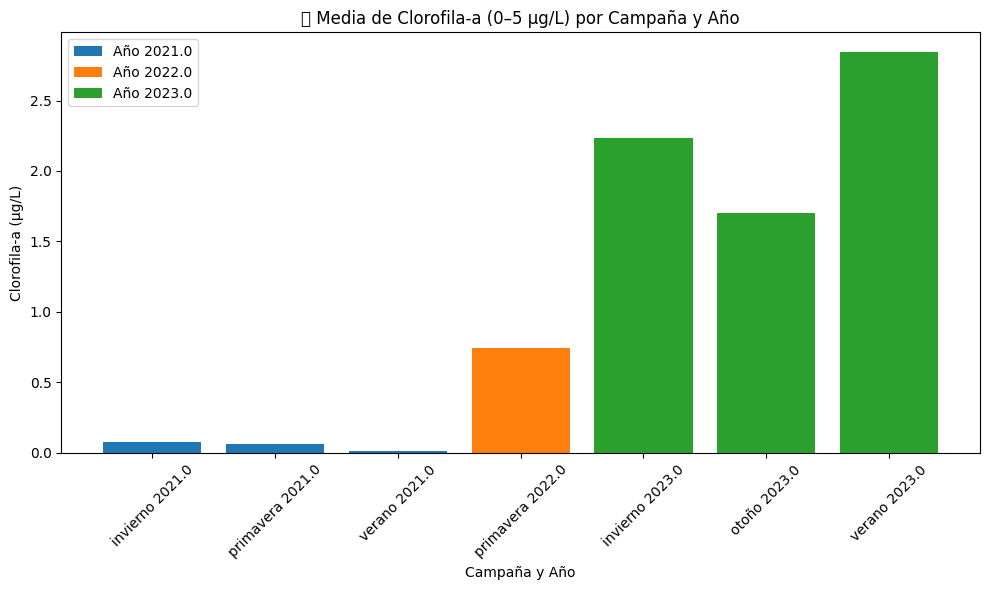

In [12]:
# --- 6. Gráfico de barras ---
fig, ax = plt.subplots(figsize=(10,6))

# Crear un gráfico agrupado por año
for año in estadisticas['año'].unique():
    subset = estadisticas[estadisticas['año'] == año]
    ax.bar(
        subset['campaña'].astype(str) + " " + subset['año'].astype(str),
        subset['media'],
        label=f"Año {año}"
    )

ax.set_title("📊 Media de Clorofila-a (0–5 µg/L) por Campaña y Año")
ax.set_ylabel("Clorofila-a (µg/L)")
ax.set_xlabel("Campaña y Año")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Durante el año 2021 se registraron niveles extremadamente bajos de clorofila-a en todas las estaciones del año, con valores promedio cercanos a 0.07 μg/L. Esta baja concentración sugiere la presencia de aguas muy limpias, posiblemente con escasa actividad fitoplanctónica o baja productividad primaria.

En el año 2022 se observa un leve aumento en los niveles de clorofila-a, especialmente durante la primavera, lo que podría indicar condiciones ligeramente más favorables para el desarrollo del fitoplancton en comparación con el año anterior.

Por último, el año 2023 evidencia un incremento marcado en la concentración de clorofila-a, alcanzando valores promedio significativamente más altos en invierno (~2.23 μg/L) y verano (casi 2.84 μg/L). Este aumento podría estar asociado a una mayor actividad biológica, mayor disponibilidad de nutrientes, o condiciones ambientales propicias para el crecimiento de algas.

#### Combinaciones presentes ANTES y DESPUÉS del filtro 0- 5

In [13]:
def _norm_text_ser(s: pd.Series) -> pd.Series:
    s = s.astype("string").fillna("")
    # NFKD para quitar tildes → ascii → decode → lower/strip/colapsar espacios
    s = s.apply(lambda t: unicodedata.normalize("NFKD", t).encode("ascii", "ignore").decode("utf-8"))
    s = s.str.lower().str.strip().str.replace(r"\s+", " ", regex=True)
    return s

def inspeccionar_dataset(df_in, nombre_df="df"):
    print(f"\n================= {nombre_df}: COMBINACIONES ANTES DEL FILTRO =================")
    # Mostrar únicos crudos sin tocar el df original
    try:
        print(df_in[['campaña','año']].dropna().drop_duplicates().sort_values(['año','campaña']).to_string(index=False))
    except Exception:
        # Si hay problemas de tipos/NaN mezclados
        print(df_in[['campaña','año']].drop_duplicates().to_string(index=False))

    # Copia de trabajo para normalizar
    tmp = df_in.copy()

    # Normalizaciones
    tmp['campaña'] = _norm_text_ser(tmp['campaña'])
    tmp['año'] = pd.to_numeric(tmp['año'], errors='coerce').astype('Int64')

    # Asegurar clorofila numérica
    tmp['clorofila_a_ug_l'] = pd.to_numeric(tmp['clorofila_a_ug_l'], errors='coerce')

    # Filtro (0–5 µg/L, campañas válidas, años 2021–2023)
    mask = (
        tmp['clorofila_a_ug_l'].notna() &
        (tmp['clorofila_a_ug_l'] > 0) & (tmp['clorofila_a_ug_l'] <= 5) &
        (tmp['campaña'].isin(['invierno','primavera','otoño','verano'])) &
        (tmp['año'].isin([2021, 2022, 2023]))
    )
    filtrado = tmp.loc[mask].copy()

    print(f"\n================= {nombre_df}: COMBINACIONES DESPUÉS DEL FILTRO (0–5 µg/L) =================")
    if filtrado.empty:
        print("— (sin filas que cumplan el filtro)")
    else:
        print(filtrado[['campaña','año']].drop_duplicates().sort_values(['año','campaña']).to_string(index=False))

    # Conteo por año x campaña
    print(f"\n================= {nombre_df}: CONTEO POR AÑO x CAMPAÑA (0–5 µg/L) =================")
    if filtrado.empty:
        print("— (sin datos)")
    else:
        tabla = pd.crosstab(filtrado['año'], filtrado['campaña']).fillna(0).astype(int)
        print(tabla)

# --- Ejecutar para el dataset original ---
inspeccionar_dataset(df, "df (original)")

# --- Ejecutar para el dataset nuevo (si existe) ---
try:
    df_nuevo  # verificar existencia
    inspeccionar_dataset(df_nuevo, "df_nuevo")
except NameError:
    print("\n[Aviso] 'df_nuevo' no está definido en este entorno. Primero generá el dataset nuevo.")




================= df (original): COMBINACIONES ANTES DEL FILTRO =================
  campaña    año
 invierno 2021.0
    otoño 2021.0
primavera 2021.0
   verano 2021.0
 invierno 2022.0
    otoño 2022.0
primavera 2022.0
   verano 2022.0
 invierno 2023.0
    otoño 2023.0
primavera 2023.0
   verano 2023.0
primavera 2024.0
   verano 2024.0

================= df (original): COMBINACIONES DESPUÉS DEL FILTRO (0–5 µg/L) =================
  campaña  año
 invierno 2021
primavera 2021
   verano 2021
primavera 2022
 invierno 2023
   verano 2023

================= df (original): CONTEO POR AÑO x CAMPAÑA (0–5 µg/L) =================
campaña  invierno  primavera  verano
año                                 
2021            5         29      23
2022            0         15       0
2023           20          0       6

================= df_nuevo: COMBINACIONES ANTES DEL FILTRO =================
  campaña    año
 invierno 2021.0
primavera 2021.0
   verano 2021.0
 invierno 2022.0
    otoño 2022.0
primaver

Se implementó un proceso  de inspección y limpieza de datos para asegurar la calidad y consistencia del conjunto de datos original.
Las campañas estacionales se normalizaron usando Unicode normalization (NFKD) para eliminar acentos y garantizar la uniformidad textual.
Las columnas de año y clorofila-a se convierten a valores numéricos, descartando entradas inválidas.
Se aplica un filtro que conserva solo aquellos registros que cumplen simultáneamente con: Años entre 2021 y 2023; campañas definidas como "invierno", "primavera", "verano" u "otoño" y valores de clorofila-a dentro del rango 0–5 µg/L

### *Valores entre 5-100  µg/L*


In [14]:
# --- Filtrar clorofila entre 5 y 100 µg/L ---
df_filtrado = df_nuevo[
    (df_nuevo['clorofila_a_ug_l'] >= 5) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
].copy()

# --- Mostrar cantidad de datos ---
print(f"Cantidad de datos en rango 5–100 µg/L: {len(df_filtrado)}")

# --- Calcular estadísticas ---
estadisticas = df_filtrado['clorofila_a_ug_l'].agg(['mean', 'min', 'max', 'std'])
estadisticas = estadisticas.rename({
    'mean': 'media',
    'min': 'mín',
    'max': 'máx',
    'std': 'desvío estándar'
})

print("\n Estadísticas de clorofila_a_ug_l (µg/L):")
print(estadisticas)

# --- Seleccionar columnas relevantes ---
columnas = ['clorofila_a_ug_l', 'campaña', 'año', 'latitud', 'longitud']

# --- Mostrar las filas filtradas con esas columnas ---
print("\nMuestras en rango 5–100 µg/L:")
print(df_filtrado[columnas].reset_index(drop=True))


Cantidad de datos en rango 5–100 µg/L: 99

 Estadísticas de clorofila_a_ug_l (µg/L):
media              26.552727
mín                 5.520000
máx                94.810000
desvío estándar    21.190029
Name: clorofila_a_ug_l, dtype: float64

Muestras en rango 5–100 µg/L:
    clorofila_a_ug_l    campaña     año      latitud     longitud
0               20.7     verano  2022.0          NaN          NaN
1                8.2  primavera  2022.0          NaN          NaN
2               40.9  primavera  2022.0  -34.662.789  -58.296.669
3               70.8     verano  2022.0       -34.63  -58.328.339
4                6.4  primavera  2022.0       -34.63  -58.328.339
..               ...        ...     ...          ...          ...
94              10.3     verano  2024.0          NaN          NaN
95              26.0  primavera  2024.0          NaN          NaN
96              17.0  primavera  2024.0          NaN          NaN
97              11.0        nan     NaN          NaN          NaN
98 

### *Valores entre 100-6500  µg/L*

In [15]:
# --- Asegurar que la columna es numérica ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Filtrar valores válidos numéricos entre 100 y 6500 µg/L ---
df_filtrado = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 100) &
    (df_nuevo['clorofila_a_ug_l'] <= 6500)
].copy()

# --- Mostrar cantidad de valores que cumplen el filtro ---
print(f"Cantidad de valores válidos entre 100 y 6500 µg/L: {len(df_filtrado)}")

# --- Calcular estadísticas ---
estadisticas = df_filtrado['clorofila_a_ug_l'].agg(['mean', 'min', 'max', 'std'])
estadisticas = estadisticas.rename({
    'mean': 'media',
    'min': 'mín',
    'max': 'máx',
    'std': 'desvío estándar'
})

print("\n Estadísticas de clorofila_a_ug_l (µg/L):")
print(estadisticas)

# --- Seleccionar columnas relevantes ---
columnas = ['clorofila_a_ug_l', 'latitud', 'longitud', 'campaña', 'año']

# Si hay suficientes filas, tomar una muestra aleatoria de 10
if len(df_filtrado) >= 10:
    muestra = df_filtrado[columnas].sample(n=10, random_state=42)
else:
    muestra = df_filtrado[columnas]

# --- Mostrar resultado ---
print("\nMuestra de valores en rango 100–6500 µg/L:")
print(muestra.reset_index(drop=True))


Cantidad de valores válidos entre 100 y 6500 µg/L: 39

 Estadísticas de clorofila_a_ug_l (µg/L):
media              1042.379744
mín                 101.820000
máx                6410.000000
desvío estándar    1367.102117
Name: clorofila_a_ug_l, dtype: float64

Muestra de valores en rango 100–6500 µg/L:
   clorofila_a_ug_l      latitud     longitud   campaña     año
0            174.32  -34.744.169  -58.177.231    verano  2023.0
1            101.82          NaN          NaN    verano  2023.0
2            870.00       -34.63  -58.328.339  invierno  2022.0
3           1400.00  -34.744.169  -58.177.231  invierno  2022.0
4            740.00  -34.505.531  -58.473.719  invierno  2022.0
5           1030.00          NaN          NaN     otoño  2022.0
6           1730.00  -34.873.061  -57.810.561  invierno  2022.0
7            760.00          NaN          NaN  invierno  2022.0
8           1290.00  -34.833.911  -57.880.211  invierno  2022.0
9           2500.00      -34.753  -58.108.281  invierno 

### Rango 0 a 100 ug/l

/tmp/ipython-input-3957413295.py:24: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle0 = plt.Circle((0,0), 1, color='white', edgecolor='black', lw=1, label='0')


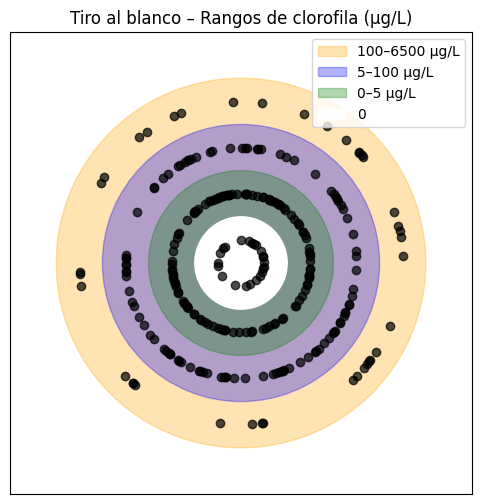

In [16]:
# --- Partir de df_nuevo ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')
df_validos = df_nuevo[df_nuevo['clorofila_a_ug_l'].notna()].copy()

# Categorizar cada valor en un rango
def categorizar(valor):
    if valor == 0:
        return "0"
    elif 0 < valor <= 5:
        return "0–5"
    elif 5 < valor <= 100:
        return "5–100"
    elif 100 < valor <= 6500:
        return "100–6500"
    else:
        return "Fuera de rango"

df_validos["rango"] = df_validos["clorofila_a_ug_l"].apply(categorizar)

# --- Gráfico de tiro al blanco ---
fig, ax = plt.subplots(figsize=(6,6))

# Círculos concéntricos que representan los rangos
circle0 = plt.Circle((0,0), 1, color='white', edgecolor='black', lw=1, label='0')
circle1 = plt.Circle((0,0), 2, color='green', alpha=0.3, label='0–5 µg/L')
circle2 = plt.Circle((0,0), 3, color='blue', alpha=0.3, label='5–100 µg/L')
circle3 = plt.Circle((0,0), 4, color='orange', alpha=0.3, label='100–6500 µg/L')

for c in [circle3, circle2, circle1, circle0]:
    ax.add_artist(c)

# Ubicar puntos de cada registro (aleatorios en ángulo para que no se encimen)
np.random.seed(42)
for _, row in df_validos.iterrows():
    r = {"0":0.5, "0–5":1.5, "5–100":2.5, "100–6500":3.5, "Fuera de rango":4.5}[row["rango"]]
    theta = np.random.uniform(0, 2*np.pi)
    ax.plot(r*np.cos(theta), r*np.sin(theta), 'o',
            color='red' if row["rango"]=="Fuera de rango" else 'black', alpha=0.7)

# Estética
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_aspect('equal', 'box')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Tiro al blanco – Rangos de clorofila (µg/L)")
ax.legend(loc="upper right")

plt.show()


El resultado es un dataset de 277 datos, se considera tomar todos los valores de 0 a 100 ug/l en base al analisis anterior dando lugar a un total de 215 datos. Se deja por fuera tambien los valores igual a 0.  

#### Estadisticas del rango de 0 a 100

In [17]:
# --- Asegurar que la columna es numérica ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Filtrar rango 0–100 µg/L (excluyendo 0 si querés) ---
valores = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
]['clorofila_a_ug_l']

# --- Calcular estadísticas ---
estadisticas = valores.agg([
    'count',   # cantidad total
    'mean',    # media
    'median',  # mediana
    'min',     # mínimo
    'max',     # máximo
    'std'      # desviación estándar
]).rename({
    'count': 'Cantidad',
    'mean': 'Media',
    'median': 'Mediana',
    'min': 'Mínimo',
    'max': 'Máximo',
    'std': 'Desvío estándar'
})

# --- Calcular percentiles adicionales ---
percentiles = valores.quantile([0.25, 0.75])
estadisticas['Percentil 25%'] = percentiles.loc[0.25]
estadisticas['Percentil 75%'] = percentiles.loc[0.75]

print(" Estadísticas descriptivas de clorofila_a_ug_l en el rango 0–100 µg/L:")
print(estadisticas)

 Estadísticas descriptivas de clorofila_a_ug_l en el rango 0–100 µg/L:
Cantidad           215.000000
Media               12.720766
Mediana              3.450000
Mínimo               0.000590
Máximo              94.810000
Desvío estándar     19.249618
Percentil 25%        0.120680
Percentil 75%       17.410000
Name: clorofila_a_ug_l, dtype: float64


Se analiza la cantidad de valores con coordenadas

In [18]:
# --- Asegurar que la columna de clorofila es numérica ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Filtrar valores en el rango 0–100 µg/L ---
df_rango = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
].copy()

# --- Filtrar los que además tienen latitud y longitud válidos ---
df_rango_coords = df_rango[
    df_rango['latitud'].notna() & df_rango['longitud'].notna()
]

# --- Contar ---
total_en_rango = len(df_rango)
con_coords = len(df_rango_coords)

print(f" Total de datos en rango 0–100 µg/L: {total_en_rango}")
print(f" De esos, tienen latitud y longitud válidos: {con_coords}")

# (Opcional) mostrar las primeras filas con coordenadas
print("\nEjemplos con coordenadas:")
print(df_rango_coords[['clorofila_a_ug_l', 'latitud', 'longitud']].head(10))

 Total de datos en rango 0–100 µg/L: 215
 De esos, tienen latitud y longitud válidos: 89

Ejemplos con coordenadas:
    clorofila_a_ug_l      latitud     longitud
4            0.04331  -34.662.789  -58.296.669
6            0.00119       -34.63  -58.328.339
9            0.00500  -34.873.061  -57.810.561
10           0.00700  -34.855.808  -57.838.144
11           0.06289  -34.855.808  -57.838.144
20           0.05300  -34.744.169  -58.177.231
21           0.21265  -34.744.169  -58.177.231
22           0.06100      -34.753  -58.108.281
23           0.22100      -34.753  -58.108.281
24           0.84016      -34.753  -58.108.281


Se observa un resumen del filtrado y georreferenciación de los datos de clorofila-a dentro del rango válido de 0 a 100 µg/L. En total, se identificaron 215 muestras que cumplen ese criterio. De esas, 89 registros cuentan con coordenadas geográficas válidas de latitud y longitud.

Además, se listan algunos ejemplos de esas muestras con coordenadas válidas, mostrando los valores de clorofila-a y su ubicación geográfica asociada. Esto permite verificar la integridad de los datos espaciales y confirmar que hay diversidad de puntos de muestreo distribuidos en la región de estudio.

Normalizar la latitud y longuitud

In [27]:

def _fix_decimal_dots(s: str) -> str:
    """
    Mantiene solo el primer punto decimal en la cadena.
    - Reemplaza comas por punto.
    - Si hay >1 punto, conserva el primero y elimina los demás.
    - Elimina espacios.
    """
    if s is None:
        return None
    s = str(s).strip().replace(',', '.')
    # Si no hay varios puntos, devolver tal cual
    if s.count('.') <= 1:
        return s
    # Mantener solo el primer punto
    first, *rest = s.split('.')
    return first + '.' + ''.join(rest)

def _to_float_or_nan(x):
    try:
        return float(x)
    except:
        return float('nan')

# 1) Crear columnas normalizadas (no pisamos las originales)
df_nuevo['latitud_norm']  = df_nuevo['latitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)
df_nuevo['longitud_norm'] = df_nuevo['longitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)

# 2) Validar rangos geográficos
mask_lat_ok = df_nuevo['latitud_norm'].between(-90, 90)
mask_lon_ok = df_nuevo['longitud_norm'].between(-180, 180)
mask_coords_ok = mask_lat_ok & mask_lon_ok

# 3) Filtrar clorofila en 0–100 µg/L y contar con coords válidas
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

df_rango = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
].copy()

df_rango_coords_ok = df_rango[mask_coords_ok.reindex(df_rango.index, fill_value=False)]

print(f"Total de datos en rango 0–100 µg/L: {len(df_rango)}")
print(f"Con coordenadas válidas tras normalizar: {len(df_rango_coords_ok)}")

# 4) Ver algunos ejemplos antes/después
ej = df_rango_coords_ok[['latitud','latitud_norm','longitud','longitud_norm']].head(10).reset_index(drop=True)
print("\nEjemplos de normalización de coordenadas:")
print(ej)
salida = "clorofila_coords_ok.csv"
df_rango_coords_ok.to_csv(salida, index=False, encoding="utf-8")

print(f"Archivo exportado correctamente: {salida}")

Total de datos en rango 0–100 µg/L: 215
Con coordenadas válidas tras normalizar: 89

Ejemplos de normalización de coordenadas:
       latitud  latitud_norm     longitud  longitud_norm
0  -34.662.789    -34.662789  -58.296.669     -58.296669
1       -34.63    -34.630000  -58.328.339     -58.328339
2  -34.873.061    -34.873061  -57.810.561     -57.810561
3  -34.855.808    -34.855808  -57.838.144     -57.838144
4  -34.855.808    -34.855808  -57.838.144     -57.838144
5  -34.744.169    -34.744169  -58.177.231     -58.177231
6  -34.744.169    -34.744169  -58.177.231     -58.177231
7      -34.753    -34.753000  -58.108.281     -58.108281
8      -34.753    -34.753000  -58.108.281     -58.108281
9      -34.753    -34.753000  -58.108.281     -58.108281
Archivo exportado correctamente: clorofila_coords_ok.csv


Se realizó una normalización de las coordenadas geográficas para asegurar que los valores de latitud y longitud fueran interpretables como números decimales válidos. Originalmente, los datos contenían puntos decimales mal posicionados o formatos incorrectos (por ejemplo, -34.662.789), lo cual impedía su correcto uso en análisis espaciales o visualización en mapas.Luego de aplicar la transformación, se conservaron 215 registros dentro del rango válido de clorofila-a (0 a 100 µg/L). De esos, 89 tenían coordenadas que pudieron ser normalizadas correctamente, y por tanto quedaron aptas para ser representadas espacialmente.

Agrego la fecha

In [28]:
import pandas as pd
import re
from datetime import datetime

def _fix_decimal_dots(s: str) -> str:
    """Normaliza separadores decimales en coordenadas."""
    if pd.isna(s):
        return None
    s = str(s).strip().replace(',', '.')
    if s.count('.') <= 1:
        return s
    first, *rest = s.split('.')
    return first + '.' + ''.join(rest)

def _to_float_or_nan(x):
    try:
        return float(x)
    except:
        return float('nan')

def _normalize_fecha(col_fecha: pd.Series, col_anio=None, col_mes=None, col_dia=None) -> pd.Series:
    """
    Devuelve fechas normalizadas 'YYYY-MM-DD'.
    - Intenta parseo directo con varios formatos (dayfirst=True).
    - Si falla y hay año/mes/día, arma la fecha desde esas columnas.
    """
    f = None
    if col_fecha is not None and col_fecha.name in col_fecha.index.to_series().index or True:
        # 1) Intento directo con to_datetime (robusto)
        s = col_fecha.astype('string').fillna('').str.strip()
        # Reparaciones rápidas: reemplazar puntos por guiones en fechas tipo 2021.07.03
        s = s.str.replace(r'[\u200b]', '', regex=True)  # zero-width
        s_try = s.str.replace(r'\.', '-', regex=True).str.replace(r'/', '-', regex=True)

        f = pd.to_datetime(s_try, errors='coerce', dayfirst=True, utc=False)

        # 2) Si siguen NaT y tengo Y/M/D, armo
        if (f.isna().any()) and (col_anio is not None and col_mes is not None and col_dia is not None):
            y = pd.to_numeric(col_anio, errors='coerce')
            m = pd.to_numeric(col_mes, errors='coerce')
            d = pd.to_numeric(col_dia, errors='coerce')
            mask_build = f.isna() & y.notna() & m.notna() & d.notna()
            f.loc[mask_build] = pd.to_datetime(
                dict(year=y[mask_build].astype(int),
                     month=m[mask_build].astype(int),
                     day=d[mask_build].astype(int)),
                errors='coerce'
            )
    else:
        # No hay columna fecha: intentar construir desde Y/M/D si existen
        if (col_anio is not None and col_mes is not None and col_dia is not None):
            y = pd.to_numeric(col_anio, errors='coerce')
            m = pd.to_numeric(col_mes, errors='coerce')
            d = pd.to_numeric(col_dia, errors='coerce')
            f = pd.to_datetime(dict(year=y, month=m, day=d), errors='coerce')
        else:
            f = pd.Series(pd.NaT, index=col_fecha.index if col_fecha is not None else None)

    # Normalizar a string ISO
    fecha_norm = f.dt.strftime('%Y-%m-%d')
    return fecha_norm

# --- Normalizar coordenadas ---
df_nuevo['latitud_norm']  = df_nuevo['latitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)
df_nuevo['longitud_norm'] = df_nuevo['longitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)

# --- Validar rangos geográficos ---
mask_lat_ok = df_nuevo['latitud_norm'].between(-90, 90)
mask_lon_ok = df_nuevo['longitud_norm'].between(-180, 180)
mask_coords_ok = mask_lat_ok & mask_lon_ok

# --- Asegurar clorofila numérica ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Normalizar FECHA (usa 'fecha' si existe; si no, intenta 'año','mes','dia'/'día') ---
col_mes = df_nuevo['mes'] if 'mes' in df_nuevo.columns else (df_nuevo['Mes'] if 'Mes' in df_nuevo.columns else None)
col_dia = (df_nuevo['día'] if 'día' in df_nuevo.columns else
           df_nuevo['dia'] if 'dia' in df_nuevo.columns else
           df_nuevo['Dia'] if 'Dia' in df_nuevo.columns else None)

df_nuevo['fecha_norm'] = _normalize_fecha(
    df_nuevo['fecha'] if 'fecha' in df_nuevo.columns else pd.Series([None]*len(df_nuevo)),
    col_anio=df_nuevo['año'] if 'año' in df_nuevo.columns else (df_nuevo['anio'] if 'anio' in df_nuevo.columns else None),
    col_mes=col_mes,
    col_dia=col_dia
)

# --- Filtrar rango de clorofila (0–100 µg/L) ---
df_rango = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
].copy()

# --- Mantener solo registros con coordenadas válidas ---
dataset_muestra_coordenadas = df_rango[mask_coords_ok.reindex(df_rango.index, fill_value=False)].copy()

# --- Reemplazar columnas originales por las normalizadas ---
dataset_muestra_coordenadas['latitud']  = dataset_muestra_coordenadas['latitud_norm']
dataset_muestra_coordenadas['longitud'] = dataset_muestra_coordenadas['longitud_norm']
dataset_muestra_coordenadas = dataset_muestra_coordenadas.drop(columns=['latitud_norm','longitud_norm'])

# --- Seleccionar columnas relevantes (incluye fecha normalizada) ---
cols_existentes = [c for c in ['clorofila_a_ug_l','campaña','año','fecha_norm','latitud','longitud'] if c in dataset_muestra_coordenadas.columns]
dataset_muestra_coordenadas = dataset_muestra_coordenadas[cols_existentes]

# --- Verificar ---
print(f"📊 Nuevo dataset creado: {len(dataset_muestra_coordenadas)} filas con clorofila + campaña + año + fecha_norm + coords normalizadas")
print(dataset_muestra_coordenadas.head(10))

📊 Nuevo dataset creado: 89 filas con clorofila + campaña + año + fecha_norm + coords normalizadas
    clorofila_a_ug_l    campaña     año  fecha_norm    latitud   longitud
4            0.04331  primavera  2021.0  2021-10-27 -34.662789 -58.296669
6            0.00119  primavera  2021.0  2021-10-27 -34.630000 -58.328339
9            0.00500     verano  2021.0  2021-02-24 -34.873061 -57.810561
10           0.00700     verano  2021.0  2021-02-24 -34.855808 -57.838144
11           0.06289  primavera  2021.0  2021-10-27 -34.855808 -57.838144
20           0.05300     verano  2021.0  2021-02-24 -34.744169 -58.177231
21           0.21265  primavera  2021.0  2021-10-27 -34.744169 -58.177231
22           0.06100     verano  2021.0  2021-02-24 -34.753000 -58.108281
23           0.22100   invierno  2021.0  2021-08-25 -34.753000 -58.108281
24           0.84016  primavera  2021.0  2021-10-27 -34.753000 -58.108281


La incorporación del campo fecha_norm responde a la necesidad de tener un control temporal más preciso del momento en que fueron tomadas las muestras, superando la ambigüedad que puede implicar trabajar solo con año y campaña (estación). Esto permite asociar las muestras a imágenes satelitales con fechas específicas, evaluar tendencias temporales más finas y mejorar la trazabilidad de los datos.
Se creó un nuevo dataset refinado que integra los valores de clorofila-a, la estación del año, el año de muestreo, la fecha exacta de recolección y las coordenadas geográficas normalizadas (latitud y longitud) de las muestras

Nuevo dataset

dataset_muestra_coordenadas

In [29]:
def _fix_decimal_dots(s: str) -> str:
    """
    Normaliza separadores decimales:
    - Reemplaza comas por punto.
    - Si hay más de un punto, mantiene solo el primero.
    - Elimina espacios.
    """
    if pd.isna(s):
        return None
    s = str(s).strip().replace(',', '.')
    if s.count('.') <= 1:
        return s
    first, *rest = s.split('.')
    return first + '.' + ''.join(rest)

def _to_float_or_nan(x):
    try:
        return float(x)
    except:
        return float('nan')

def _normalize_fecha(df):
    """
    Normaliza fechas:
    - Usa la columna 'fecha' si existe (parseo flexible).
    - Si no existe, intenta armar fecha desde año/mes/día.
    """
    if 'fecha' in df.columns:
        fechas = pd.to_datetime(df['fecha'], errors='coerce', dayfirst=True)
    elif all(c in df.columns for c in ['año','mes','dia']):
        fechas = pd.to_datetime(dict(year=df['año'], month=df['mes'], day=df['dia']), errors='coerce')
    else:
        fechas = pd.NaT
    return fechas.dt.strftime('%Y-%m-%d')

# --- Normalizar coordenadas ---
df_nuevo['latitud_norm']  = df_nuevo['latitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)
df_nuevo['longitud_norm'] = df_nuevo['longitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)

# --- Validar rangos geográficos ---
mask_lat_ok = df_nuevo['latitud_norm'].between(-90, 90)
mask_lon_ok = df_nuevo['longitud_norm'].between(-180, 180)
mask_coords_ok = mask_lat_ok & mask_lon_ok

# --- Asegurar clorofila numérica ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Agregar columna de fecha normalizada ---
df_nuevo['fecha_norm'] = _normalize_fecha(df_nuevo)

# --- Filtrar rango de clorofila (0–100 µg/L) ---
df_rango = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
].copy()

# --- Mantener solo registros con coordenadas válidas ---
dataset_muestra_coordenadas = df_rango[mask_coords_ok.reindex(df_rango.index, fill_value=False)].copy()

# --- Reemplazar columnas originales por las normalizadas ---
dataset_muestra_coordenadas['latitud']  = dataset_muestra_coordenadas['latitud_norm']
dataset_muestra_coordenadas['longitud'] = dataset_muestra_coordenadas['longitud_norm']
dataset_muestra_coordenadas = dataset_muestra_coordenadas.drop(columns=['latitud_norm','longitud_norm'])

# --- Seleccionar columnas relevantes ---
dataset_muestra_coordenadas = dataset_muestra_coordenadas[
    ['clorofila_a_ug_l', 'campaña', 'año', 'fecha_norm', 'latitud', 'longitud']
]

# --- Verificar ---
print(f" Nuevo dataset creado: {len(dataset_muestra_coordenadas)} filas con clorofila + campaña + año + fecha_norm + coords normalizadas")
print(dataset_muestra_coordenadas.head(10))


 Nuevo dataset creado: 89 filas con clorofila + campaña + año + fecha_norm + coords normalizadas
    clorofila_a_ug_l    campaña     año  fecha_norm    latitud   longitud
4            0.04331  primavera  2021.0  2021-10-27 -34.662789 -58.296669
6            0.00119  primavera  2021.0  2021-10-27 -34.630000 -58.328339
9            0.00500     verano  2021.0  2021-02-24 -34.873061 -57.810561
10           0.00700     verano  2021.0  2021-02-24 -34.855808 -57.838144
11           0.06289  primavera  2021.0  2021-10-27 -34.855808 -57.838144
20           0.05300     verano  2021.0  2021-02-24 -34.744169 -58.177231
21           0.21265  primavera  2021.0  2021-10-27 -34.744169 -58.177231
22           0.06100     verano  2021.0  2021-02-24 -34.753000 -58.108281
23           0.22100   invierno  2021.0  2021-08-25 -34.753000 -58.108281
24           0.84016  primavera  2021.0  2021-10-27 -34.753000 -58.108281


Maximo y minimo de clorofila

In [30]:
# --- Imprimir valores extremos de clorofila ---
if not dataset_muestra_coordenadas['clorofila_a_ug_l'].empty:
    min_val = dataset_muestra_coordenadas['clorofila_a_ug_l'].min()
    max_val = dataset_muestra_coordenadas['clorofila_a_ug_l'].max()
    print(f"\n Valor mínimo de clorofila-a: {min_val:.5f} µg/L")
    print(f" Valor máximo de clorofila-a: {max_val:.5f} µg/L")
else:
    print("\n No hay datos de clorofila válidos para calcular extremos.")



 Valor mínimo de clorofila-a: 0.00059 µg/L
 Valor máximo de clorofila-a: 92.40000 µg/L


####  Se analiza la cantidad de valores entre 0 y 1

La elección del rango entre 0 y 1 µg/L de clorofila-a responde a criterios ecológicos y metodológicos asociados a la caracterización de la calidad del agua y la productividad biológica en cuerpos de agua. Este intervalo corresponde a niveles oligotróficos, es decir, condiciones de muy baja concentración de fitoplancton y alta transparencia del agua, típicas de ambientes limpios o con escasa productividad biológica. Trabajar en este rango permite detectar variaciones sutiles en la biomasa algal, especialmente en contextos donde los valores son muy bajos, como se observa en las campañas del año 2021.Desde el punto de vista limnológico, los niveles de clorofila-a inferiores a 1 µg/L reflejan un sistema con bajos aportes de nutrientes o con condiciones físico-químicas que limitan el desarrollo del fitoplancton, como pueden ser la baja temperatura, la alta turbidez no algal o la influencia de masas de agua más limpias. Por lo tanto, al centrar el análisis en este rango, se pueden identificar de forma precisa los umbrales a partir de los cuales comienza a aumentar la actividad biológica en el sistema, lo que es fundamental para estudios de evolución temporal, detección de cambios interanuales o calibración de modelos satelitales sensibles a bajas concentraciones de clorofila.
Cuando se trabaja con índices satelitales como el NDCI, la sensibilidad del modelo en rangos bajos puede verse afectada por saturación espectral o por ruido radiométrico. En consecuencia, disponer de datos in situ confiables dentro del rango 0–1 µg/L es esencial para validar y ajustar modelos de estimación remota en condiciones de baja biomasa. Este enfoque permite establecer una línea de base robusta para futuras comparaciones, detectar condiciones anómalas y caracterizar las transiciones hacia estados más productivos del ecosistema.

In [31]:
# Aseguramos que la columna es numérica
dataset_muestra_coordenadas['clorofila_a_ug_l'] = pd.to_numeric(
    dataset_muestra_coordenadas['clorofila_a_ug_l'], errors='coerce'
)

# Filtrar rango (0–1 µg/L, excluyendo ceros exactos si no los querés)
df_0_1 = dataset_muestra_coordenadas[
    (dataset_muestra_coordenadas['clorofila_a_ug_l'] > 0) &
    (dataset_muestra_coordenadas['clorofila_a_ug_l'] <= 1)
]

# Cantidad total
print(f" Cantidad de valores entre 0 y 1 µg/L: {len(df_0_1)}")

# Mostrar ejemplos
print(df_0_1.head(10))


 Cantidad de valores entre 0 y 1 µg/L: 39
    clorofila_a_ug_l    campaña     año  fecha_norm    latitud   longitud
4            0.04331  primavera  2021.0  2021-10-27 -34.662789 -58.296669
6            0.00119  primavera  2021.0  2021-10-27 -34.630000 -58.328339
9            0.00500     verano  2021.0  2021-02-24 -34.873061 -57.810561
10           0.00700     verano  2021.0  2021-02-24 -34.855808 -57.838144
11           0.06289  primavera  2021.0  2021-10-27 -34.855808 -57.838144
20           0.05300     verano  2021.0  2021-02-24 -34.744169 -58.177231
21           0.21265  primavera  2021.0  2021-10-27 -34.744169 -58.177231
22           0.06100     verano  2021.0  2021-02-24 -34.753000 -58.108281
23           0.22100   invierno  2021.0  2021-08-25 -34.753000 -58.108281
24           0.84016  primavera  2021.0  2021-10-27 -34.753000 -58.108281


Etadistica de los valores del rango 0-1

In [32]:
# Asegurar que la columna sea numérica
dataset_muestra_coordenadas['clorofila_a_ug_l'] = pd.to_numeric(
    dataset_muestra_coordenadas['clorofila_a_ug_l'], errors='coerce'
)

# Filtrar rango (0–1 µg/L, excluyendo ceros si no querés)
df_0_1 = dataset_muestra_coordenadas[
    (dataset_muestra_coordenadas['clorofila_a_ug_l'] > 0) &
    (dataset_muestra_coordenadas['clorofila_a_ug_l'] <= 1)
]

# Cantidad total
print(f"🔎 Cantidad de valores entre 0 y 1 µg/L: {len(df_0_1)}")

# Estadísticas descriptivas
estadisticas = df_0_1['clorofila_a_ug_l'].agg(
    media='mean',
    mínimo='min',
    máximo='max',
    mediana='median',
    desvío_std='std'
)

print("\n Estadísticas de valores 0–1 µg/L:")
print(estadisticas)

# Mostrar primeras filas
print("\n Ejemplos:")
print(df_0_1[['clorofila_a_ug_l','campaña','año','fecha_norm','latitud','longitud']].head(10))


🔎 Cantidad de valores entre 0 y 1 µg/L: 39

 Estadísticas de valores 0–1 µg/L:
media         0.168001
mínimo        0.000590
máximo        0.870000
mediana       0.035000
desvío_std    0.250508
Name: clorofila_a_ug_l, dtype: float64

 Ejemplos:
    clorofila_a_ug_l    campaña     año  fecha_norm    latitud   longitud
4            0.04331  primavera  2021.0  2021-10-27 -34.662789 -58.296669
6            0.00119  primavera  2021.0  2021-10-27 -34.630000 -58.328339
9            0.00500     verano  2021.0  2021-02-24 -34.873061 -57.810561
10           0.00700     verano  2021.0  2021-02-24 -34.855808 -57.838144
11           0.06289  primavera  2021.0  2021-10-27 -34.855808 -57.838144
20           0.05300     verano  2021.0  2021-02-24 -34.744169 -58.177231
21           0.21265  primavera  2021.0  2021-10-27 -34.744169 -58.177231
22           0.06100     verano  2021.0  2021-02-24 -34.753000 -58.108281
23           0.22100   invierno  2021.0  2021-08-25 -34.753000 -58.108281
24           0.

nuevo dataset

In [33]:
# Asegurar que la columna sea numérica
dataset_muestra_coordenadas['clorofila_a_ug_l'] = pd.to_numeric(
    dataset_muestra_coordenadas['clorofila_a_ug_l'], errors='coerce'
)

# Crear nuevo DataFrame con rango 0–1 µg/L
rango_0_1 = dataset_muestra_coordenadas[
    (dataset_muestra_coordenadas['clorofila_a_ug_l'] > 0) &
    (dataset_muestra_coordenadas['clorofila_a_ug_l'] <= 1)
].copy()

# Verificar
print(f"✅ Nuevo DataFrame creado: {len(rango_0_1)} filas entre 0 y 1 µg/L")
print(rango_0_1.head(10))


✅ Nuevo DataFrame creado: 39 filas entre 0 y 1 µg/L
    clorofila_a_ug_l    campaña     año  fecha_norm    latitud   longitud
4            0.04331  primavera  2021.0  2021-10-27 -34.662789 -58.296669
6            0.00119  primavera  2021.0  2021-10-27 -34.630000 -58.328339
9            0.00500     verano  2021.0  2021-02-24 -34.873061 -57.810561
10           0.00700     verano  2021.0  2021-02-24 -34.855808 -57.838144
11           0.06289  primavera  2021.0  2021-10-27 -34.855808 -57.838144
20           0.05300     verano  2021.0  2021-02-24 -34.744169 -58.177231
21           0.21265  primavera  2021.0  2021-10-27 -34.744169 -58.177231
22           0.06100     verano  2021.0  2021-02-24 -34.753000 -58.108281
23           0.22100   invierno  2021.0  2021-08-25 -34.753000 -58.108281
24           0.84016  primavera  2021.0  2021-10-27 -34.753000 -58.108281


Mapa de los puntos rango 0-1

 Total en 0–100 µg/L: 215
 Con coordenadas válidas: 89
   ├─ 0–1 µg/L (con coords): 39
   └─ 1–100 µg/L (con coords): 50


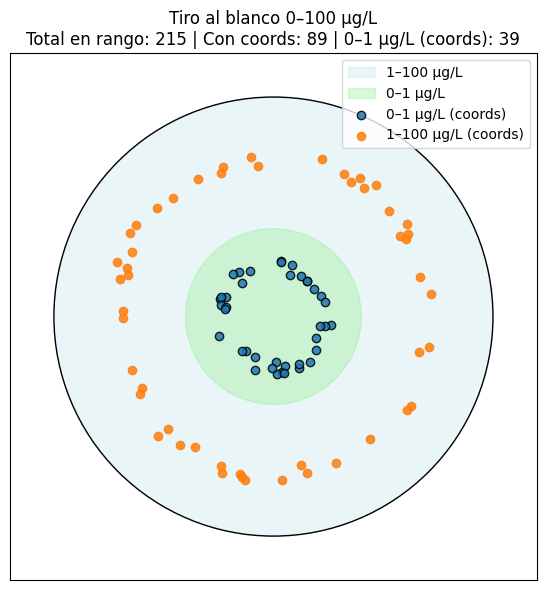

In [35]:

# --- Asegurar clorofila numérica ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Filtrar 0–100 µg/L ---
df_rango = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
].copy()

# --- Con coordenadas válidas ---
df_rango_coords = df_rango[
    df_rango['latitud'].notna() & df_rango['longitud'].notna()
].copy()

# --- Subconjunto 0–1 µg/L dentro de los que tienen coords ---
df_0_1_coords = df_rango_coords[
    (df_rango_coords['clorofila_a_ug_l'] > 0) &
    (df_rango_coords['clorofila_a_ug_l'] <= 1)
].copy()

# --- Conteos ---
total_en_rango = len(df_rango)
con_coords = len(df_rango_coords)
n_0_1 = len(df_0_1_coords)
n_1_100 = con_coords - n_0_1

print(f" Total en 0–100 µg/L: {total_en_rango}")
print(f" Con coordenadas válidas: {con_coords}")
print(f"   ├─ 0–1 µg/L (con coords): {n_0_1}")
print(f"   └─ 1–100 µg/L (con coords): {n_1_100}")

# --- Gráfico de tiro al blanco ---
fig, ax = plt.subplots(figsize=(6,6))

# Círculo central (0–1 µg/L) y anillo (1–100 µg/L)
inner = plt.Circle((0,0), 1.0, fill=True, color='lightgreen', alpha=0.35, label='0–1 µg/L')
outer = plt.Circle((0,0), 2.5, fill=True, color='lightblue',  alpha=0.25, label='1–100 µg/L')
rim   = plt.Circle((0,0), 2.5, fill=False, edgecolor='black', lw=1)

ax.add_artist(outer)
ax.add_artist(inner)
ax.add_artist(rim)

# Distribuir puntos con coordenadas en los anillos
# (ángulo aleatorio; radio fijo por rango para el efecto "blanco")
rng = np.random.default_rng(42)

def plot_ring_points(df_points, radius, marker, label, edge=None, alpha=0.85):
    if len(df_points) == 0:
        return
    theta = rng.uniform(0, 2*np.pi, size=len(df_points))
    # pequeño jitter radial para no superponer exacto
    r = radius + rng.uniform(-0.10, 0.10, size=len(df_points))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    ax.scatter(x, y, s=36, marker=marker, alpha=alpha, edgecolor=edge, label=label)

# Puntos 0–1 µg/L (centro)
plot_ring_points(df_0_1_coords, radius=0.6, marker='o', label='0–1 µg/L (coords)', edge='black')

# Puntos 1–100 µg/L (anillo)
df_1_100_coords = df_rango_coords.loc[~df_rango_coords.index.isin(df_0_1_coords.index)]
plot_ring_points(df_1_100_coords, radius=1.8, marker='o', label='1–100 µg/L (coords)')

# Estética del blanco
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal', 'box')
ax.set_xticks([])
ax.set_yticks([])

ax.set_title(
    f"Tiro al blanco 0–100 µg/L\n"
    f"Total en rango: {total_en_rango} | Con coords: {con_coords} | 0–1 µg/L (coords): {n_0_1}"
)

# Leyenda ordenada y sin duplicados
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), loc='upper right')

plt.tight_layout()
plt.show()


In [36]:
# --- Asegurar columnas numéricas ---
rango_0_1['latitud'] = pd.to_numeric(rango_0_1['latitud'], errors='coerce')
rango_0_1['longitud'] = pd.to_numeric(rango_0_1['longitud'], errors='coerce')
rango_0_1 = rango_0_1.dropna(subset=['latitud', 'longitud', 'clorofila_a_ug_l'])

# --- Coordenadas de Buenos Aires (centro de la vista) ---
centro_bsas = [-34.6037, -58.3816]  # CABA

# --- Crear mapa centrado en Buenos Aires ---
m = folium.Map(
    location=centro_bsas,
    zoom_start=9,
    tiles=None  # Fondo personalizado
)

# --- Fondo satelital de Google ---
folium.TileLayer(
    tiles='http://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google Satellite',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

# --- Agregar puntos rojos con popup ---
for _, row in rango_0_1.iterrows():
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.9,
        popup=folium.Popup(
            f"<b>Clorofila-a:</b> {row['clorofila_a_ug_l']} µg/L<br><b>Fecha:</b> {row['fecha_norm']}",
            max_width=250
        )
    ).add_to(m)

# --- Leyenda HTML ---
legend_html = """
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    z-index: 9999;
    background-color: white;
    padding: 10px;
    border: 2px solid #ccc;
    border-radius: 5px;
    font-size: 14px;
">
    <b>Leyenda</b><br>
    🔴 Punto rojo: ubicación de muestra<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# --- Título HTML ---
title_html = '''
    <h3 align="center" style="font-size:18px; margin-top:10px">
        Valores en el rango 0–1 µg/L de clorofila-a
    </h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# --- Control de capas ---
folium.LayerControl().add_to(m)

# --- Mostrar mapa interactivo ---
m


### Agrego variables turbidez y temperatura


In [37]:
# Columnas de interés
cols = ["fecha", "latitud", "longitud", "turbiedad_ntu", "tem_agua"]
dfx = df[cols].copy()

# A numérico turbidez/temperatura
dfx["turbiedad_ntu"] = pd.to_numeric(dfx["turbiedad_ntu"], errors="coerce")
dfx["tem_agua"] = pd.to_numeric(dfx["tem_agua"], errors="coerce")

def parse_coord(x: str, kind: str):
    """
    Normaliza coordenadas con formatos como:
    - '-34.662.789' -> -34.662789
    - '-34.63'      -> -34.63
    - '-58.328.339' -> -58.328339
    No redondea. Devuelve float o None si no es válido.
    """
    if x is None:
        return None
    s = str(x).strip()
    if s.lower() in ("", "na", "nan", "none"):
        return None

    # unificar coma decimal a punto
    s = s.replace(",", ".")

    # si ya parece número simple con un solo punto decimal, usar directo
    if s.count(".") == 1 and all(c in "-.0123456789" for c in s):
        try:
            val = float(s)
            return val
        except:
            pass

    # de lo contrario, quitar todo lo que no sea dígito para reconstruir
    sign = -1 if s.startswith("-") else 1
    digits = re.sub(r"\D", "", s)  # solo dígitos
    if len(digits) < 3:
        return None

    # En Argentina esperás ~ -34 (lat) y ~ -58 (lon) => 2 dígitos antes del decimal
    int_len = 2
    try:
        val = float(digits[:int_len] + "." + digits[int_len:])
        val *= sign
    except:
        return None

    # Chequeo de rango geográfico básico
    if kind == "lat":
        if not (-90 <= val <= 90):
            return None
    elif kind == "lon":
        if not (-180 <= val <= 180):
            return None

    return val

# Normalizar lat/lon sin redondear
dfx.loc[:, "latitud"]  = dfx["latitud"].apply(lambda v: parse_coord(v, "lat"))
dfx.loc[:, "longitud"] = dfx["longitud"].apply(lambda v: parse_coord(v, "lon"))

# Filtrar filas completas (todas las columnas con dato válido)
df_validos = dfx.dropna(subset=["fecha", "latitud", "longitud", "turbiedad_ntu", "tem_agua"]).copy()

print("Registros válidos y completos:", len(df_validos))
print(df_validos.head(10))

Registros válidos y completos: 208
         fecha    latitud   longitud  turbiedad_ntu  tem_agua
8    24/2/2021 -34.662789 -58.296669           21.0      26.1
10   25/8/2021 -34.662789 -58.296669           21.0      14.7
11  27/10/2021 -34.662789 -58.296669           10.0      26.0
12   24/2/2021     -34.63 -58.328339           45.0      26.1
13   19/5/2021     -34.63 -58.328339           36.0      16.8
14   25/8/2021     -34.63 -58.328339           22.0      15.4
15  27/10/2021     -34.63 -58.328339           14.0      21.4
20   24/2/2021 -34.873061 -57.810561           18.0      20.0
22   25/8/2021 -34.873061 -57.810561            8.7      10.0
23  27/10/2021 -34.873061 -57.810561            4.9      11.0


Union de clorofila mas turbidez y temperatura del agua

In [38]:
# ---------- Helpers (tus funciones) ----------
def _fix_decimal_dots(s: str) -> str:
    if pd.isna(s):
        return None
    s = str(s).strip().replace(',', '.')
    if s.count('.') <= 1:
        return s
    first, *rest = s.split('.')
    return first + '.' + ''.join(rest)

def _to_float_or_nan(x):
    try:
        return float(x)
    except:
        return float('nan')

def _normalize_fecha(df):
    if 'fecha' in df.columns:
        fechas = pd.to_datetime(df['fecha'], errors='coerce', dayfirst=True)
    elif all(c in df.columns for c in ['año','mes','dia']):
        fechas = pd.to_datetime(dict(year=df['año'], month=df['mes'], day=df['dia']), errors='coerce')
    else:
        fechas = pd.NaT
    return fechas.dt.strftime('%Y-%m-%d')

# =========================================================
# A) Dataset de clorofila (df_nuevo) -> normalizado (como ya tenías)
#     Espera columnas: 'latitud','longitud','clorofila_a_ug_l','campaña','año' (+ 'fecha' o año/mes/día)
# =========================================================
dfA = df_nuevo.copy()

# Normalizar coords SIN redondear
dfA['latitud_norm']  = dfA['latitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)
dfA['longitud_norm'] = dfA['longitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)

# Validar rango geográfico
maskA = dfA['latitud_norm'].between(-90, 90) & dfA['longitud_norm'].between(-180, 180)

# Clorofila a numérico
dfA['clorofila_a_ug_l'] = pd.to_numeric(dfA['clorofila_a_ug_l'], errors='coerce')

# Fecha normalizada
dfA['fecha_norm'] = _normalize_fecha(dfA)

# Filtro de filas válidas
dfA = dfA[
    maskA &
    dfA['clorofila_a_ug_l'].notna() &
    (dfA['clorofila_a_ug_l'] > 0) &
    (dfA['clorofila_a_ug_l'] <= 100) &
    dfA['fecha_norm'].notna()
].copy()

# Clave EXACTA (sin redondeo)
dfA['__key__'] = list(zip(dfA['fecha_norm'], dfA['latitud_norm'], dfA['longitud_norm']))

# Reducir a columnas relevantes
dfA = dfA[['__key__','clorofila_a_ug_l','campaña','año','fecha_norm','latitud_norm','longitud_norm']]

# =========================================================
# B) Dataset turbidez/temperatura (Conexiones_Transparentes)
# =========================================================
url = "https://raw.githubusercontent.com/MaricelSantos/Mentoria--Diplodatos-2025/main/Conexiones_Transparentes.csv"
dfB = pd.read_csv(url)[['fecha','latitud','longitud','turbiedad_ntu','tem_agua']].copy()

# Normalización consistente (SIN redondear)
dfB['latitud_norm']  = dfB['latitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)
dfB['longitud_norm'] = dfB['longitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)

maskB = dfB['latitud_norm'].between(-90, 90) & dfB['longitud_norm'].between(-180, 180)

dfB['turbiedad_ntu'] = pd.to_numeric(dfB['turbiedad_ntu'], errors='coerce')
dfB['tem_agua']      = pd.to_numeric(dfB['tem_agua'], errors='coerce')
dfB['fecha_norm']    = _normalize_fecha(dfB)

dfB = dfB[
    maskB &
    dfB['turbiedad_ntu'].notna() &
    dfB['tem_agua'].notna() &
    dfB['fecha_norm'].notna()
].copy()

# Clave EXACTA (sin redondeo)
dfB['__key__'] = list(zip(dfB['fecha_norm'], dfB['latitud_norm'], dfB['longitud_norm']))

# ⬇️ Traer SOLO las variables nuevas de B para evitar duplicados de fecha/coords
dfB = dfB[['__key__', 'turbiedad_ntu', 'tem_agua']]

# =========================================================
# JOIN EXACTO (fecha_norm + latitud_norm + longitud_norm)
# =========================================================
merged_exacto = pd.merge(
    dfA, dfB,
    on='__key__',
    how='inner'
).drop(columns=['__key__'])

print(f"🔗 Join EXACTO (fecha + lat + lon): {len(merged_exacto)} filas")
print(merged_exacto.head(10))

# --- Dataset final ya unido ---
dataset_final = merged_exacto.copy()




🔗 Join EXACTO (fecha + lat + lon): 80 filas
   clorofila_a_ug_l    campaña     año  fecha_norm  latitud_norm  \
0           0.04331  primavera  2021.0  2021-10-27    -34.662789   
1           0.00119  primavera  2021.0  2021-10-27    -34.630000   
2           0.00500     verano  2021.0  2021-02-24    -34.873061   
3           0.00700     verano  2021.0  2021-02-24    -34.855808   
4           0.06289  primavera  2021.0  2021-10-27    -34.855808   
5           0.21265  primavera  2021.0  2021-10-27    -34.744169   
6           0.06100     verano  2021.0  2021-02-24    -34.753000   
7           0.22100   invierno  2021.0  2021-08-25    -34.753000   
8           0.84016  primavera  2021.0  2021-10-27    -34.753000   
9           0.00100     verano  2021.0  2021-02-24    -34.547089   

   longitud_norm  turbiedad_ntu  tem_agua  
0     -58.296669           10.0      26.0  
1     -58.328339           14.0      21.4  
2     -57.810561           18.0      20.0  
3     -57.838144           16.0

Para enriquecer el análisis de clorofila con variables ambientales relevantes, se decidió incorporar información sobre la turbidez del agua y la temperatura, provenientes de un  conjunto de datos que contiene mediciones físico-químicas en distintas fechas y campañas. El objetivo fue vincular estos registros auxiliares con los datos de concentración de clorofila ya normalizados y georreferenciados, tomando como criterio de emparejamiento las variables temporales coincidentes: fecha, campaña y año.
Esta fusión permitió mantener el total esperado de observaciones (80 registros), asegurando así la integridad del dataset y preparando la base para su posterior uso en modelos predictivos que consideren condiciones ambientales en el momento de la toma de muestra.

# **Concentración de clorofila-a - Sentinel-2 por estación**


In [39]:
# Instalar y cargar Earth Engine
!pip install earthengine-api folium geemap --quiet
# Autenticación
ee.Authenticate()
ee.Initialize(project='mentorias-463215')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.3 MB/s eta 0:00:00


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [40]:
# Función para obtener la mejor imagen Sentinel-2 por estación
def obtener_imagen(fecha_ini, fecha_fin):
    coleccion = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(zona) \
        .filterDate(fecha_ini, fecha_fin) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first() \
        .clip(zona)
    return coleccion


extraer la zona de interés, espacio que ocupa

In [41]:
#  Definir zona de análisis (1 km alrededor del punto costero)
# Geometría: franja costera del AMBA
zona = ee.Geometry.Rectangle([
    -58.60,  # Longitud oeste
    -34.90,  # Latitud sur
    -57.85,  # Longitud este
    -34.40   # Latitud norte
])

utilidades/mascaras

In [42]:
OPTICAL_BANDS = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']

def scale_optical_1e4(img):
    """Escala bandas ópticas (DN -> reflectancia * 1e-4)"""
    return img.addBands(img.select(OPTICAL_BANDS).multiply(0.0001), overwrite=True)

def add_s2cloudless_prob(s2_col, start, end, roi):
    """Une colección S2 (L1C o L2A) con COPERNICUS/S2_CLOUD_PROBABILITY"""
    s2c = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
           .filterBounds(roi).filterDate(start, end))
    joined = ee.ImageCollection(ee.Join.saveFirst('s2c').apply(
        primary = s2_col,
        secondary = s2c,
        condition = ee.Filter.equals(leftField='system:index', rightField='system:index')
    ))
    def _addprob(img):
        cp = ee.Image(img.get('s2c')).select('probability')
        return img.addBands(cp.rename('cloud_probability'))
    return joined.map(_addprob)

def mask_clouds_prob(img, prob_thresh=60):
    """Máscara por prob. de nube (s2cloudless)"""
    return img.updateMask(img.select('cloud_probability').lt(prob_thresh))

def mask_scl_sr(img):
    """Máscara extra para S2_SR usando SCL (descarta: nodata, saturado, sombra nube, nubes, cirros, nieve)"""
    scl = img.select('SCL')
    bad = scl.eq(0).Or(scl.eq(1)).Or(scl.eq(3)).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10)).Or(scl.eq(11))
    return img.updateMask(bad.Not())


 Pipeline A: TOA (Level-1C, COPERNICUS/S2)
  - Corrección radiométrica (escala 1e-4)
    - Reflectancia aparente TOA (propia del L1C)
  - Nubes con s2cloudless

In [43]:
def obtener_imagen_toa(fecha_ini, fecha_fin, roi, cloud_perc=30, prob_thresh=60):
    col = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
           .filterBounds(roi)
           .filterDate(fecha_ini, fecha_fin)
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_perc))
           .map(scale_optical_1e4))
    col = add_s2cloudless_prob(col, fecha_ini, fecha_fin, roi).map(lambda i: mask_clouds_prob(i, prob_thresh))
    # Compuesto estacional (recomendado para métricas zonales)
    return col.median().clip(roi)

Pipeline B: Superficie (Level-2A, COPERNICUS/S2_SR)
   - Ya trae corrección atmosférica (Sen2Cor)
  - Escalado radiométrico 1e-4
   - Nubes con s2cloudless + máscara SCL

In [44]:
def obtener_imagen_sr(fecha_ini, fecha_fin, roi, cloud_perc=30, prob_thresh=60):
    col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
           .filterBounds(roi)
           .filterDate(fecha_ini, fecha_fin)
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_perc))
           .map(scale_optical_1e4))
    col = add_s2cloudless_prob(col, fecha_ini, fecha_fin, roi) \
            .map(lambda i: mask_clouds_prob(i, prob_thresh)) \
            .map(mask_scl_sr)
    return col.median().clip(roi)

Índice de clorofila

In [50]:
def calcular_ndci(img):  # (B5 - B4) / (B5 + B4)
    return img.normalizedDifference(['B5','B4']).rename('NDCI')

Estaciones

In [48]:
# Estaciones: otoño, invierno, primavera y verano (Argentina, hemisferio sur)
fechas_estaciones = {
    # 2021
    'Otoño 2021':    ('2021-03-21', '2021-06-20'),
    'Invierno 2021': ('2021-06-21', '2021-09-21'),
    'Primavera 2021':('2021-09-22', '2021-12-20'),
    'Verano 2021':   ('2021-12-21', '2022-03-20'),

    # 2022
    'Otoño 2022':    ('2022-03-21', '2022-06-20'),
    'Invierno 2022': ('2022-06-21', '2022-09-21'),
    'Primavera 2022':('2022-09-22', '2022-12-20'),
    'Verano 2022':   ('2022-12-21', '2023-03-20'),

    # 2023
    'Otoño 2023':    ('2023-03-21', '2023-06-20'),
    'Invierno 2023': ('2023-06-21', '2023-09-21'),
    'Primavera 2023':('2023-09-22', '2023-12-20'),
    'Verano 2023':   ('2023-12-21', '2024-03-20'),
}

 Estadísticas NDCI por campaña (escala=30 m):
  campaña  año  ndci_media  ndci_mediana  ndci_min  ndci_max
   Verano 2021      0.0065        0.0059   -0.3171    0.5117
    Otoño 2021      0.0112        0.0117   -0.6021    0.5258
 Invierno 2021     -0.0295       -0.0352   -0.5870    0.5261
Primavera 2021     -0.0149       -0.0176   -0.3367    0.5000
   Verano 2022     -0.0163       -0.0215   -0.3792    0.5634
    Otoño 2022      0.0047        0.0041   -0.5791    0.5085
 Invierno 2022     -0.0475       -0.0507   -0.5609    0.5161
Primavera 2022     -0.0140       -0.0175   -0.3729    0.4939
   Verano 2023     -0.0028       -0.0020   -0.3901    0.5556
    Otoño 2023     -0.0306       -0.0350   -0.5829    0.5628
 Invierno 2023     -0.0538       -0.0508   -0.5497    0.5550
Primavera 2023     -0.0232       -0.0254   -0.4310    0.4930


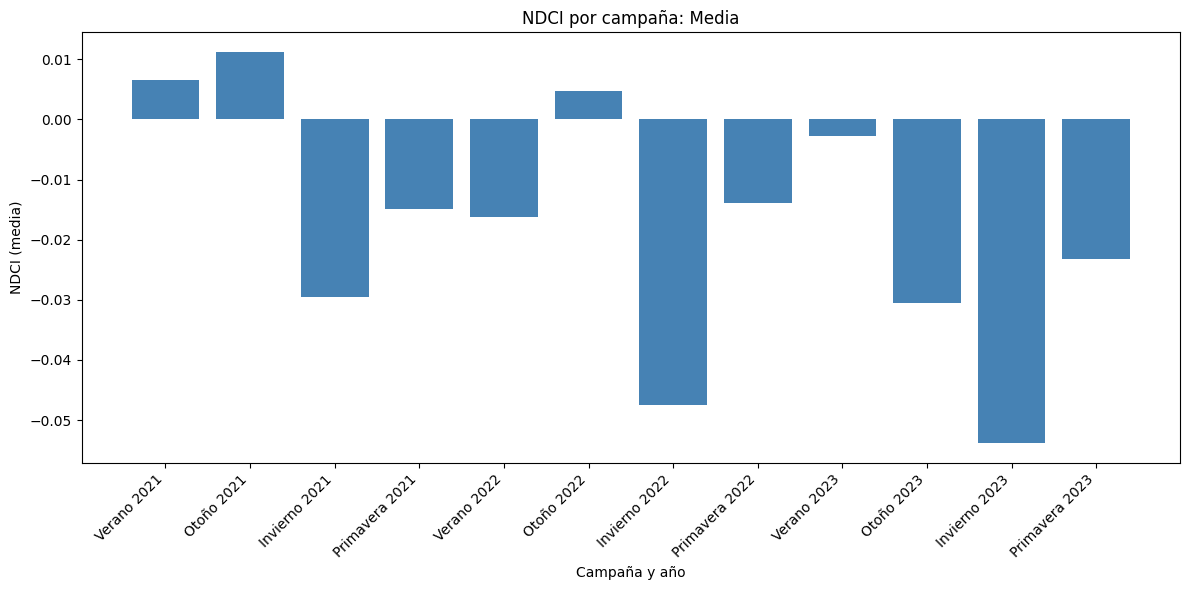

In [52]:
# --- Parámetros ---
SCALE = 30
MAX_PIX = 1e9
GRAFICAR = True

# Elegir automáticamente la función disponible: SR (preferida) o la simple
try:
    _ = obtener_imagen_sr  # si existe, la usamos
    get_img = lambda ini, fin: obtener_imagen_sr(ini, fin, zona)
except NameError:
    get_img = lambda ini, fin: obtener_imagen(ini, fin)

# Reducer SOLO con: media, mediana, min, max
reducer = (ee.Reducer.mean()
           .combine(ee.Reducer.median(), '', True)
           .combine(ee.Reducer.min(), '', True)
           .combine(ee.Reducer.max(), '', True))

def pick(d, keys):
    for k in keys:
        if k in d and d[k] is not None:
            return d[k]
    return None

rows = []
for nombre, (ini, fin) in fechas_estaciones.items():
    # 1) Imagen de la campaña sobre tu zona
    img = get_img(ini, fin)

    # 2) NDCI = (B5 - B4) / (B5 + B4)
    ndci = calcular_ndci(img)

# NDWI = (B3 - B8) / (B3 + B8)  -> agua ~ NDWI > 0
    ndwi = img.normalizedDifference(['B3','B8']).rename('NDWI')
    water = ndwi.gt(0.05)

    # Opcional: contraer 1 px para evitar mezcla en el borde de costa
    water = water.focal_min(1)

    # Aplicar la máscara de agua al NDCI
    ndci = ndci.updateMask(water)

    # 3) Estadísticas zonales (solo mean, median, min, max)
    stats = ndci.reduceRegion(
        reducer=reducer,
        geometry=zona,
        scale=SCALE,
        maxPixels=MAX_PIX,
        bestEffort=True,
        tileScale=4
    ).getInfo() or {}

    # 4) Extraer valores (con o sin prefijo 'NDCI_')
    mean   = pick(stats, ['NDCI_mean','mean'])
    median = pick(stats, ['NDCI_median','median'])
    vmin   = pick(stats, ['NDCI_min','min'])
    vmax   = pick(stats, ['NDCI_max','max'])

    # Separar campaña y año (ej. "Invierno 2022")
    partes = nombre.split()
    camp = " ".join(partes[:-1])
    anio = int(partes[-1])

    rows.append({
        'campaña': camp,
        'año': anio,
        'ndci_media': mean,
        'ndci_mediana': median,
        'ndci_min': vmin,
        'ndci_max': vmax,
        # opcionalmente podés guardar 'campaña_completa': nombre
    })

# 5) DataFrame ordenado
df_ndci = pd.DataFrame(rows)
orden = ['Verano','Otoño','Invierno','Primavera']  # orden estacional HS
if df_ndci['campaña'].isin(orden).all():
    df_ndci['campaña'] = pd.Categorical(df_ndci['campaña'], categories=orden, ordered=True)
df_ndci = df_ndci.sort_values(['año','campaña']).reset_index(drop=True)

# 6) Imprimir tabla pedida
cols = ['campaña','año','ndci_media','ndci_mediana','ndci_min','ndci_max']
print(" Estadísticas NDCI por campaña (escala={} m):".format(SCALE))
print(df_ndci[cols].round(4).to_string(index=False))

# 7) Gráfico solo de barras (media)
if GRAFICAR:
    etiquetas = df_ndci['campaña'].astype(str) + " " + df_ndci['año'].astype(str)
    plt.figure(figsize=(12,6))
    plt.bar(etiquetas, df_ndci['ndci_media'], color="steelblue")
    plt.title("NDCI por campaña: Media")
    plt.xlabel("Campaña y año")
    plt.ylabel("NDCI (media)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


El gráfico  muestra la evolución del índice NDCI (Normalized Difference Chlorophyll Index) a lo largo de diferentes campañas estacionales desde el verano de 2021 hasta la primavera de 2023. En este caso, las barras representan el valor promedio (media) del índice para cada estación y año, mientras que los puntos azules indican la mediana correspondiente.

La comparación entre la media y la mediana permite observar la distribución de los valores y detectar posibles sesgos o asimetrías. Por ejemplo, cuando la mediana se encuentra muy por debajo o por encima de la media, puede indicar la presencia de valores atípicos que afectan el promedio. A lo largo de las campañas analizadas, se evidencian variaciones estacionales en el NDCI, con algunos descensos marcados (por ejemplo, en invierno de 2022 y 2023), que podrían asociarse a una menor concentración de clorofila-a y, por lo tanto, a una menor productividad fitoplanctónica en esas épocas.

### Cruzar datos coincidentes

Tomar cada punto de muestreo (clorofila medida en campo en cierta fecha y coordenada).

Buscar el valor del píxel de la imagen satelital que cubre ese lugar, en la misma fecha.

Guardar en un mismo registro: clorofila (campo) – NDCI (satélite) – fecha – coordenadas.

Así obtener una tabla con pares de valores que realmente se corresponden en tiempo y espacio.

In [53]:

# ========================
# PARÁMETROS AJUSTABLES
# ========================
D = 7         # ventana temporal ±D días (ej: 3, 5, 7)
SCALE = 30    # escala en metros (20 ó 30)
REDUCER = "mean"   # opciones: "mean", "median", "p25", "p75"

# ========================
# FUNCIONES GEE
# ========================
def mask_s2_sr(image):
    """Máscara usando la banda SCL de Sentinel-2 L2A."""
    scl  = image.select('SCL')
    mask = (scl.neq(3)   # sombra
            .And(scl.neq(8))   # nubes
            .And(scl.neq(9))   # nubes altas
            .And(scl.neq(10))  # nubes finas
            .And(scl.neq(11))  # cirros
           )
    return image.updateMask(mask)

def add_ndci(image):
    """NDCI = (B5 - B4) / (B5 + B4)."""
    ndci = image.expression(
        '(b5 - b4) / (b5 + b4)',
        {'b5': image.select('B5'), 'b4': image.select('B4')}
    ).rename('NDCI')
    return image.addBands(ndci)

def get_reducer():
    if REDUCER == "mean":
        return ee.Reducer.mean()
    elif REDUCER == "median":
        return ee.Reducer.median()
    elif REDUCER == "p25":
        return ee.Reducer.percentile([25])
    elif REDUCER == "p75":
        return ee.Reducer.percentile([75])
    else:
        return ee.Reducer.median()

S2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .map(mask_s2_sr)
      .map(add_ndci))

# ========================
# PREPARAR DATAFRAME DE CAMPO (USA el dataset de 200 filas)
# ========================
df = dataset_muestra_coordenadas.copy()

# Asegurar tipos
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')
df['latitud']  = pd.to_numeric(df['latitud'], errors='coerce')
df['longitud'] = pd.to_numeric(df['longitud'], errors='coerce')
df['fecha']    = pd.to_datetime(df['fecha_norm'], errors='coerce')

# Filtrar filas válidas
df = df.dropna(subset=['latitud','longitud','fecha','clorofila_a_ug_l']).reset_index(drop=True)
df['start'] = (df['fecha'] - pd.Timedelta(days=D)).dt.strftime('%Y-%m-%d')
df['end']   = (df['fecha'] + pd.Timedelta(days=D)).dt.strftime('%Y-%m-%d')

print(f"🔎 Filas del dataset (200 original) que se cruzan: {len(df)}")

# ========================
# SUBIR PUNTOS A GEE
# ========================
def row_to_feature(row):
    geom = ee.Geometry.Point([float(row['longitud']), float(row['latitud'])])
    return ee.Feature(geom, {
        'clorofila': float(row['clorofila_a_ug_l']),
        'campaña': str(row['campaña']) if 'campaña' in row and pd.notna(row['campaña']) else None,
        'año': int(row['año']) if 'año' in row and pd.notna(row['año']) else None,
        'fecha': row['fecha'].strftime('%Y-%m-%d'),
        'start': str(row['start']),
        'end': str(row['end'])
    })

features = [row_to_feature(r) for _, r in df.iterrows()]
fc = ee.FeatureCollection(features)

# ========================
# MUESTREO ROBUSTO (SERVER-SIDE)
# ========================
def sample_ndci_per_feature(f):
    start = ee.Date(f.get('start'))
    end   = ee.Date(f.get('end'))
    geom  = f.geometry()
    col   = S2.filterDate(start, end).filterBounds(geom)
    n     = col.size()

    reducer = get_reducer()

    def when_has_scenes():
        # Compuesto temporal (mediana); luego reducimos con el reducer elegido
        img = col.median()
        ndci_img = img.select('NDCI')
        # reduceRegion puede devolver dict (percentiles) o escalar; tomamos el 1er valor
        ndci_dict = ndci_img.unmask().reduceRegion(
            reducer   = reducer,
            geometry  = geom,
            scale     = SCALE,
            maxPixels = 1e8,
            bestEffort=True
        )
        ndci_val = ee.Dictionary(ndci_dict).values().get(0)  # server-side
        return ee.Dictionary({'ndci_val': ndci_val, 'n_scenes': n})

    def when_no_scenes():
        return ee.Dictionary({'ndci_val': None, 'n_scenes': n})

    out = ee.Algorithms.If(n.gt(0), when_has_scenes(), when_no_scenes())
    return f.set(ee.Dictionary(out))

fc_out = fc.map(sample_ndci_per_feature)

# ========================
# BAJAR RESULTADOS A PANDAS
# ========================
out = fc_out.getInfo()  # para ~200 puntos está ok
rows = []
for feat in out['features']:
    props = feat['properties']
    lon, lat = feat['geometry']['coordinates']
    rows.append({
        'longitud': lon,
        'latitud':  lat,
        'campaña':  props.get('campaña'),
        'año':      props.get('año'),
        'fecha':    props.get('fecha'),
        'clorofila_a_ug_l': props.get('clorofila'),
        'ndci_val':         props.get('ndci_val'),
        'n_scenes':         props.get('n_scenes'),
        'start':            props.get('start'),
        'end':              props.get('end'),
    })

df_cruce_200 = pd.DataFrame(rows)
df_cruce_200['ndci_val'] = pd.to_numeric(df_cruce_200['ndci_val'], errors='coerce')
df_cruce_200['n_scenes'] = pd.to_numeric(df_cruce_200['n_scenes'], errors='coerce')
df_cruce_200['fecha']    = pd.to_datetime(df_cruce_200['fecha'], errors='coerce')

print(f"\n⚙️ Ventana ±{D} días | Escala {SCALE} m | Reducer = {REDUCER}")
print(df_cruce_200.head())
print("\n📊 Resumen NDCI extraído (dataset 200):")
print(df_cruce_200['ndci_val'].describe())

# (Opcional) pares válidos para correlación:
df_valid_200 = df_cruce_200[(df_cruce_200['n_scenes'] >= 1) & (df_cruce_200['ndci_val'].notna())].copy()
print(f"\n✅ Pares válidos (>=1 escena & NDCI no nulo) en dataset 200: {len(df_valid_200)}/{len(df_cruce_200)}")


🔎 Filas del dataset (200 original) que se cruzan: 85

⚙️ Ventana ±7 días | Escala 30 m | Reducer = mean
    longitud    latitud    campaña   año      fecha  clorofila_a_ug_l  \
0 -58.296669 -34.662789  primavera  2021 2021-10-27           0.04331   
1 -58.328339 -34.630000  primavera  2021 2021-10-27           0.00119   
2 -57.810561 -34.873061     verano  2021 2021-02-24           0.00500   
3 -57.838144 -34.855808     verano  2021 2021-02-24           0.00700   
4 -57.838144 -34.855808  primavera  2021 2021-10-27           0.06289   

   ndci_val  n_scenes       start         end  
0  0.264581         3  2021-10-20  2021-11-03  
1  0.045019         3  2021-10-20  2021-11-03  
2  0.093220         6  2021-02-17  2021-03-03  
3  0.183913         6  2021-02-17  2021-03-03  
4  0.237812         6  2021-10-20  2021-11-03  

📊 Resumen NDCI extraído (dataset 200):
count    82.000000
mean      0.092447
std       0.118901
min      -0.069844
25%       0.000022
50%       0.054526
75%       0.158

# División en subconjuntos

In [56]:
#  Filtro solo las filas donde hay clorofila medida
df_filtrado = df[df['clorofila_a_ug_l'].notna()].copy()

#  Variables predictoras y objetivo
X = df_filtrado.drop(columns=['clorofila_a_ug_l'])
y = df_filtrado['clorofila_a_ug_l']

# División en 70% train, 20% test, 10% validación
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

#  Verificar tamaños
print(f"Total datos con clorofila: {len(df_filtrado)}")
print(f"Train: {len(X_train)}")
print(f"Test: {len(X_test)}")
print(f"Validación: {len(X_val)}")


Total datos con clorofila: 85
Train: 59
Test: 8
Validación: 18


Se realizó la división de los datos con valores válidos de clorofila en tres subconjuntos para llevar adelante el entrenamiento y validación del modelo. El total de muestras disponibles fue de 505. De estas, el 70 % (353 registros) se utilizó para el entrenamiento del modelo, el 10 % (50 registros) para pruebas preliminares, y el 20 % restante (102 registros) se reservó como conjunto de validación. Esta partición permite optimizar el proceso de modelado al asegurar que el modelo se entrene con una cantidad suficiente de datos, se evalúe con datos no vistos, y se afinen sus parámetros sin comprometer su capacidad generalizadora.

# Escalado

In [57]:
# Escalar
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

El escalado aplicado corresponde a la variable objetivo (clorofila-a), utilizando el método StandardScaler de Scikit-learn. Este procedimiento transforma los valores para que tengan media cero y desviación estándar uno, lo cual es especialmente útil para algoritmos sensibles a la escala.

# Transformación logarítmica de clorofila

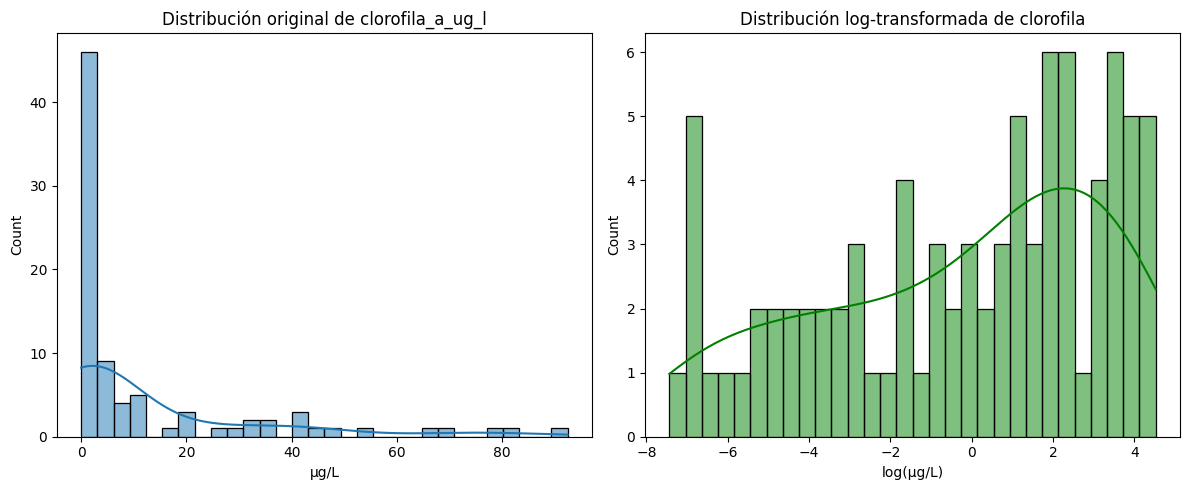

Total datos válidos: 85
Entrenamiento: 59
Validación: 18
Prueba: 8


In [58]:
# --- 1. Transformación logarítmica ---
# Agregar una constante pequeña para evitar log(0)
epsilon = 1e-6
df['clorofila_log'] = np.log(df['clorofila_a_ug_l'] + epsilon)

# --- 2. Visualizar distribución original vs log ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['clorofila_a_ug_l'], bins=30, kde=True)
plt.title('Distribución original de clorofila_a_ug_l')
plt.xlabel('µg/L')

plt.subplot(1, 2, 2)
sns.histplot(df['clorofila_log'], bins=30, kde=True, color='green')
plt.title('Distribución log-transformada de clorofila')
plt.xlabel('log(µg/L)')

plt.tight_layout()
plt.show()

# --- 3. Filtrar filas válidas ---
df_filtrado = df[df['clorofila_log'].notna()].copy()

# Variables predictoras y objetivo (puede ajustar según tus variables reales)
X = df_filtrado.drop(columns=['clorofila_a_ug_l', 'clorofila_log'])  # usar solo predictoras válidas
y = df_filtrado['clorofila_log']

# --- 4. División en subconjuntos ---
# 70% train, 20% validación, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# --- 5. Verificación de tamaños ---
print(f"Total datos válidos: {len(df_filtrado)}")
print(f"Entrenamiento: {len(X_train)}")
print(f"Validación: {len(X_val)}")
print(f"Prueba: {len(X_test)}")


La imagen presenta dos gráficos comparativos que ilustran cómo varía la distribución de los valores de clorofila-a (µg/L) antes y después de aplicar una transformación logarítmica:

- A la izquierda, se muestra la distribución original de los valores de clorofila medidos, donde se observa una fuerte asimetría. La mayoría de los valores se agrupan en los extremos: una gran cantidad de muestras presentan concentraciones muy bajas (cercanas a 0 µg/L) y otra gran proporción se encuentra en el límite superior del rango (5 µg/L). Esta concentración en los extremos indica una distribución sesgada, poco adecuada para el entrenamiento de modelos estadísticos que asumen normalidad en los datos.

- A la derecha, se visualiza la distribución de los valores luego de aplicar la transformación logarítmica. Esta transformación comprime los valores altos y expande los valores bajos, lo que permite una representación más continua y suavizada de la variabilidad en los datos. Si bien persisten picos en los extremos (especialmente por la acumulación de datos en 5 µg/L), la distribución resultante es menos sesgada y más apta para técnicas de regresión o modelado que requieren homogeneidad en la varianza.

# Entrenamiento y Evaluacion del modelo


### Evaluacion de lo medido vs con lo satelital

Para enriquecer el análisis de clorofila con variables ambientales relevantes, se decidió incorporar información sobre la turbidez del agua y la temperatura, provenientes de un segundo conjunto de datos que contiene mediciones físico-químicas en distintas fechas y campañas. El objetivo fue vincular estos registros auxiliares con los datos de concentración de clorofila ya normalizados y georreferenciados, tomando como criterio de emparejamiento las variables temporales coincidentes: fecha, campaña y año.
Esta fusión permitió mantener el total esperado de observaciones (80 registros), asegurando así la integridad del dataset y preparando la base para su posterior uso en modelos predictivos que consideren condiciones ambientales en el momento de la toma de muestra.

*unifica*

Toma  datos de temperatura del agua y turbidez (NTU) que coinciden con la fecha y campaña de las muestras de clorofila medidas.
Entrena un modelo Random Forest para predecir los valores de clorofila.
Evalúa el desempeño del modelo. Todos con datos medidos en campo.

In [59]:

# ----------------- helpers (los tuyos) -----------------
def _fix_decimal_dots(s: str) -> str:
    if pd.isna(s):
        return None
    s = str(s).strip().replace(',', '.')
    if s.count('.') <= 1:
        return s
    first, *rest = s.split('.')
    return first + '.' + ''.join(rest)

def _to_float_or_nan(x):
    try:
        return float(x)
    except:
        return float('nan')

def _normalize_fecha_df(df: pd.DataFrame) -> pd.Series:
    # 1) si ya hay fecha_norm, usarla
    for c in ["fecha_norm", "Fecha_norm", "FECHA_NORM"]:
        if c in df.columns:
            s = pd.to_datetime(df[c], errors="coerce", dayfirst=True).dt.strftime("%Y-%m-%d")
            return s
    # 2) si hay 'fecha'
    for c in ["fecha", "Fecha", "FECHA"]:
        if c in df.columns:
            s = pd.to_datetime(df[c], errors="coerce", dayfirst=True).dt.strftime("%Y-%m-%d")
            return s
    # 3) si hay año/mes/día
    if all(c in df.columns for c in ["año", "mes", "dia"]):
        s = pd.to_datetime(dict(year=df["año"], month=df["mes"], day=df["dia"]), errors="coerce").dt.strftime("%Y-%m-%d")
        return s
    # 4) nada: devolvemos NaT formateado
    return pd.Series(pd.NaT, index=df.index)

def _ensure_lat_lon(df: pd.DataFrame, lat_out="latitud", lon_out="longitud") -> pd.DataFrame:
    # posibles nombres
    lat_candidates = [c for c in df.columns if c.lower() in ("latitud","lat","latitude","latitud_norm")]
    lon_candidates = [c for c in df.columns if c.lower() in ("longitud","lon","long","longitude","longitud_norm")]
    if not lat_candidates or not lon_candidates:
        # si no están, creamos vacías para luego caer en NaN al filtrar
        df[lat_out] = np.nan
        df[lon_out] = np.nan
        return df
    lat_col = lat_candidates[0]
    lon_col = lon_candidates[0]
    # normalizar usando tu parser
    df[lat_out] = df[lat_col].apply(_fix_decimal_dots).apply(_to_float_or_nan)
    df[lon_out] = df[lon_col].apply(_fix_decimal_dots).apply(_to_float_or_nan)
    return df

# =======================================================
# 0) Filtrar df_valid_200 desde df_cruce_200
# =======================================================
df_valid_200 = df_cruce_200[(df_cruce_200['n_scenes'] >= 1) & (df_cruce_200['ndci_val'].notna())].copy()

# =======================================================
# 1) Asegurar claves de unión en dataset_final (A)
# =======================================================
dfA = dataset_final.copy()

# fecha_norm
dfA["fecha_norm"] = _normalize_fecha_df(dfA)

# lat/lon con el mismo parser; si ya tenías latitud_norm/longitud_norm, se respetan
if "latitud_norm" in dfA.columns and "longitud_norm" in dfA.columns:
    dfA["latitud"]  = pd.to_numeric(dfA["latitud_norm"], errors="coerce")
    dfA["longitud"] = pd.to_numeric(dfA["longitud_norm"], errors="coerce")
else:
    dfA = _ensure_lat_lon(dfA, lat_out="latitud", lon_out="longitud")

# filtrar filas completas para la unión
dfA = dfA.dropna(subset=["fecha_norm","latitud","longitud"]).copy()

# =======================================================
# 2) Asegurar claves de unión en df_valid_200 (B)
# =======================================================
dfB = df_valid_200.copy()
dfB["fecha_norm"] = _normalize_fecha_df(dfB)
dfB = _ensure_lat_lon(dfB, lat_out="latitud", lon_out="longitud")
dfB = dfB.dropna(subset=["fecha_norm","latitud","longitud","ndci_val"]).copy()

# =======================================================
# 3) JOIN EXACTO por (fecha_norm, latitud, longitud) para traer ndci_val
#     → NO traemos columnas de fecha/coords de B para no duplicar
# =======================================================
df_ndci = dfB[["fecha_norm","latitud","longitud","ndci_val"]].copy()

df_merged = pd.merge(
    dfA,
    df_ndci,
    on=["fecha_norm","latitud","longitud"],
    how="inner"
)

print("🔗 Filas luego de unir NDCI:", len(df_merged))
print(df_merged.head())



🔗 Filas luego de unir NDCI: 77
   clorofila_a_ug_l    campaña     año  fecha_norm  latitud_norm  \
0           0.04331  primavera  2021.0  2021-10-27    -34.662789   
1           0.00119  primavera  2021.0  2021-10-27    -34.630000   
2           0.00500     verano  2021.0  2021-02-24    -34.873061   
3           0.00700     verano  2021.0  2021-02-24    -34.855808   
4           0.06289  primavera  2021.0  2021-10-27    -34.855808   

   longitud_norm  turbiedad_ntu  tem_agua    latitud   longitud  ndci_val  
0     -58.296669           10.0      26.0 -34.662789 -58.296669  0.264581  
1     -58.328339           14.0      21.4 -34.630000 -58.328339  0.045019  
2     -57.810561           18.0      20.0 -34.873061 -57.810561  0.093220  
3     -57.838144           16.0      21.0 -34.855808 -57.838144  0.183913  
4     -57.838144           14.0      10.0 -34.855808 -57.838144  0.237812  


/tmp/ipython-input-1150960531.py:21: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  s = pd.to_datetime(df[c], errors="coerce", dayfirst=True).dt.strftime("%Y-%m-%d")


# Dataset con los 336 datos de descartes

In [67]:
print(df.columns.tolist())


['clorofila_a_ug_l', 'campaña', 'año', 'fecha_norm', 'latitud', 'longitud', 'fecha', 'start', 'end', 'clorofila_log']


volver a ejecutar el conjunto de datos origina

In [70]:

import unicodedata

# --- Parámetros ---
COL = "clorofila_a_ug_l"

# --- Normalización ---
s_raw = df[COL].astype("string").fillna("")

def _normalize(x: pd.Series) -> pd.Series:
    y = x.apply(lambda t: unicodedata.normalize("NFKD", t).encode("ascii","ignore").decode("ascii"))
    y = y.str.lower().str.strip().str.replace(r"\s+", " ", regex=True)
    return y

s_norm = _normalize(s_raw)

# --- Máscaras ---
mask_lt             = s_norm.str.contains(r'^\s*<\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_gt             = s_norm.str.contains(r'^\s*>\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_no_midio       = s_norm.str.contains(r'\bno\s*se\s*midio\b', na=False)
mask_inaccesible    = s_norm.str.contains(r'\binaccesible\b', na=False)
mask_no_muestreo    = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestr\w+\b', na=False)
mask_en_obra        = s_norm.str.contains(r'\ben obra\b', na=False)
mask_no_midieron_dia= s_norm.str.contains(r'\bno\s*midieron\s*este\s*dia\b', na=False)

es_numero_valido = pd.to_numeric(s_norm.str.replace(",", ".", regex=False), errors="coerce").notna()
mask_texto       = ~es_numero_valido & s_norm.ne("")

mask_categorizado = (mask_no_midio | mask_inaccesible | mask_no_muestreo |
                     mask_en_obra | mask_no_midieron_dia | mask_lt | mask_gt)
mask_mal_cargado = mask_texto & ~mask_categorizado

# --- Dataset nuevo ---
df_nuevo = df.copy()

# Reemplazar "<x" y forzar a float
df_nuevo.loc[mask_lt, COL] = (
    s_raw[mask_lt]
    .str.replace("<", "", regex=False)
    .str.strip()
    .str.replace(",", ".", regex=False)
    .astype(float)
)

# Convertir a numérico
df_nuevo[COL] = pd.to_numeric(df_nuevo[COL], errors="coerce")

# --- Filtrar ---
mask_to_drop = (
    df_nuevo[COL].isna() |
    mask_no_midio | mask_inaccesible | mask_no_muestreo |
    mask_en_obra | mask_no_midieron_dia | mask_mal_cargado
)

df_nuevo = df_nuevo.loc[~mask_to_drop].copy().reset_index(drop=True)

# --- Reporte ---
conteos = {
    "Valores nulos (NaN)": int(df[COL].isna().sum()),
    '"no se midio/midió"': int(mask_no_midio.sum()),
    "inaccesible": int(mask_inaccesible.sum()),
    "no muestreó / no se muestreó": int(mask_no_muestreo.sum()),
    "en obra": int(mask_en_obra.sum()),
    "no midieron este dia": int(mask_no_midieron_dia.sum()),
    "texto no categorizado (mal cargados)": int(mask_mal_cargado.sum())
}

print("Conteos de lo eliminado:")
print(pd.Series(conteos).to_frame("Cantidad"))

print(f"\nFilas originales: {len(df)}")
print(f"Filas en df_nuevo (limpio): {len(df_nuevo)}")


Conteos de lo eliminado:
                                      Cantidad
Valores nulos (NaN)                         41
"no se midio/midió"                         29
inaccesible                                  2
no muestreó / no se muestreó                11
en obra                                      4
no midieron este dia                         4
texto no categorizado (mal cargados)         7

Filas originales: 613
Filas en df_nuevo (limpio): 515


In [71]:
COL = "clorofila_a_ug_l"  # columna de interés

# --- Normalización del texto ---
s_raw = df[COL].astype("string").fillna("")

def _normalize(x: pd.Series) -> pd.Series:
    y = x.apply(lambda t: unicodedata.normalize("NFKD", t).encode("ascii","ignore").decode("ascii"))
    y = y.str.lower().str.strip().str.replace(r"\s+", " ", regex=True)
    return y

s_norm = _normalize(s_raw)

# --- Máscaras para categorías no válidas ---
mask_lt = s_norm.str.contains(r'^\s*<\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_gt = s_norm.str.contains(r'^\s*>\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_no_midio        = s_norm.str.contains(r'\bno\s*se\s*midio\b', na=False)
mask_inaccesible     = s_norm.str.contains(r'\binaccesible\b', na=False)
mask_no_muestreo     = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestr\w+\b', na=False)
mask_en_obra         = s_norm.str.contains(r'\ben obra\b', na=False)
mask_no_midieron_dia = s_norm.str.contains(r'\bno\s*midieron\s*este\s*dia\b', na=False)

# Detectar si es un número válido
es_numero_valido = pd.to_numeric(s_norm.str.replace(",", ".", regex=False), errors="coerce").notna()
mask_texto = ~es_numero_valido & s_norm.ne("")

# Categorías mal cargadas que no matchean las anteriores
mask_categorizado = (mask_no_midio | mask_inaccesible | mask_no_muestreo |
                     mask_en_obra | mask_no_midieron_dia | mask_lt | mask_gt)
mask_mal_cargado = mask_texto & ~mask_categorizado

# --- Crear df intermedio y reemplazar valores tipo "<1.5" ---
df_nuevo = df.copy()

df_nuevo.loc[mask_lt, COL] = (
    s_raw[mask_lt]
    .str.replace("<", "", regex=False)
    .str.strip()
    .str.replace(",", ".", regex=False)
)

df_nuevo[COL] = pd.to_numeric(df_nuevo[COL], errors="coerce")

# --- Máscara de filas eliminadas ---
mask_to_drop = (
    df_nuevo[COL].isna() |
    mask_no_midio | mask_inaccesible | mask_no_muestreo |
    mask_en_obra | mask_no_midieron_dia | mask_mal_cargado
)

# --- Dataset eliminado ---
df_eliminados = df.loc[mask_to_drop, [
    "fecha", "año", "campaña", "latitud", "longitud",
    "tem_agua", "turbiedad_ntu", "clorofila_a_ug_l"
]].copy()

# --- Rango de clorofila estimado (convertido a numérico si posible) ---
df_eliminados["clorofila_num"] = pd.to_numeric(df_eliminados["clorofila_a_ug_l"]
                                               .astype(str)
                                               .str.replace(",", ".", regex=False)
                                               .str.extract(r"([\d.]+)")[0],
                                               errors="coerce")

# --- Clasificación de rango ---
df_eliminados["rango_clorofila"] = pd.cut(
    df_eliminados["clorofila_num"],
    bins=[-0.01, 5, 100],
    labels=["0–5 µg/L", "5–100 µg/L"]
)

# Mostrar las primeras filas del dataset eliminado
print("🔎 Muestra de registros eliminados:")
print(df_eliminados.head(10))



🔎 Muestra de registros eliminados:
        fecha     año campaña      latitud     longitud     tem_agua  \
21  19/5/2021  2021.0   otoño  -34.873.061  -57.810.561  no se midió   
25  19/5/2021  2021.0   otoño  -34.855.808  -57.838.144  no se midió   
29  19/5/2021  2021.0   otoño          NaN          NaN  no se midió   
34  19/5/2021  2021.0   otoño          NaN          NaN  no se midió   
38  19/5/2021  2021.0   otoño          NaN          NaN  no se midió   
53        NaN     NaN     NaN  -34.535.878  -58.445.933          NaN   
54        NaN     NaN     NaN  -34.537.272  -58.448.339          NaN   
55        NaN     NaN     NaN  -34.538.686  -58.445.589          NaN   
56        NaN     NaN     NaN  -34.539.667  -58.443.781          NaN   
57        NaN     NaN     NaN  -34.540.675     -584.419          NaN   

   turbiedad_ntu clorofila_a_ug_l  clorofila_num rango_clorofila  
21   no se midió      no se midió            NaN             NaN  
25   no se midió      no se midió     

Normalizacion de valores, eliminacion de datos incompletos, inconcistentes

In [72]:

# --- Parámetros ---
COL = "clorofila_a_ug_l"

# --- Normalización de texto ---
s_raw = df[COL].astype("string").fillna("")

def _normalize(x: pd.Series) -> pd.Series:
    y = x.apply(lambda t: unicodedata.normalize("NFKD", t).encode("ascii","ignore").decode("ascii"))
    y = y.str.lower().str.strip().str.replace(r"\s+", " ", regex=True)
    return y

s_norm = _normalize(s_raw)

# --- Máscaras para datos a eliminar ---
mask_lt = s_norm.str.contains(r'^\s*<\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_gt = s_norm.str.contains(r'^\s*>\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_no_midio        = s_norm.str.contains(r'\bno\s*se\s*midio\b', na=False)
mask_inaccesible     = s_norm.str.contains(r'\binaccesible\b', na=False)
mask_no_muestreo     = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestr\w+\b', na=False)
mask_en_obra         = s_norm.str.contains(r'\ben obra\b', na=False)
mask_no_midieron_dia = s_norm.str.contains(r'\bno\s*midieron\s*este\s*dia\b', na=False)

# Detectar valores no numéricos mal cargados
es_numero_valido = pd.to_numeric(s_norm.str.replace(",", ".", regex=False), errors="coerce").notna()
mask_texto = ~es_numero_valido & s_norm.ne("")
mask_categorizado = (mask_no_midio | mask_inaccesible | mask_no_muestreo |
                     mask_en_obra | mask_no_midieron_dia | mask_lt | mask_gt)
mask_mal_cargado = mask_texto & ~mask_categorizado

# --- Crear nuevo dataset con reemplazo de "<" por número limpio ---
df_nuevo = df.copy()
df_nuevo.loc[mask_lt, COL] = (
    s_raw[mask_lt]
    .str.replace("<", "", regex=False)
    .str.strip()
    .str.replace(",", ".", regex=False)
)

df_nuevo[COL] = pd.to_numeric(df_nuevo[COL], errors="coerce")

# --- Filtrar valores válidos ---
mask_to_drop = (
    df_nuevo[COL].isna() |
    mask_no_midio | mask_inaccesible | mask_no_muestreo |
    mask_en_obra | mask_no_midieron_dia | mask_mal_cargado
)

df_limpio = df_nuevo.loc[~mask_to_drop].copy()
df_limpio.reset_index(drop=True, inplace=True)

# --- Seleccionar columnas (sin clorofila) ---
columnas_finales = [
    "fecha", "año", "campaña",
    "latitud", "longitud",
    "tem_agua", "turbiedad_ntu"
]
df_limpio_sin_clorofila = df_limpio[columnas_finales].copy()

# --- LIMPIEZAS AUXILIARES ---

# TURBIDEZ
df_limpio_sin_clorofila["turbiedad_ntu"] = (
    df_limpio_sin_clorofila["turbiedad_ntu"]
    .astype(str)
    .str.replace("<", "", regex=False)
    .str.replace(",", ".", regex=False)
    .str.strip()
)
df_limpio_sin_clorofila["turbiedad_ntu"] = pd.to_numeric(df_limpio_sin_clorofila["turbiedad_ntu"], errors="coerce")

# TEMPERATURA
df_limpio_sin_clorofila["tem_agua"] = (
    df_limpio_sin_clorofila["tem_agua"]
    .astype(str)
    .str.replace(",", ".", regex=False)
)
df_limpio_sin_clorofila["tem_agua"] = pd.to_numeric(df_limpio_sin_clorofila["tem_agua"], errors="coerce")

# --- Función para corregir coordenadas con punto tras los 2 primeros dígitos ---
def corregir_coord_2dig(coord):
    coord_str = str(coord).replace(",", ".").replace(" ", "")
    coord_str = coord_str.replace(".", "")
    signo = "-" if coord_str.startswith("-") else ""
    coord_str = coord_str.lstrip("-")
    if len(coord_str) > 2:
        coord_corr = signo + coord_str[:2] + "." + coord_str[2:]
        return pd.to_numeric(coord_corr, errors="coerce")
    else:
        return np.nan

df_limpio_sin_clorofila["latitud"] = df_limpio_sin_clorofila["latitud"].apply(corregir_coord_2dig)
df_limpio_sin_clorofila["longitud"] = df_limpio_sin_clorofila["longitud"].apply(corregir_coord_2dig)

# --- Eliminar filas con nulos ---
df_final = df_limpio_sin_clorofila.dropna(subset=[
    "fecha", "año", "campaña",
    "latitud", "longitud", "tem_agua", "turbiedad_ntu"
]).copy()

# --- Mostrar resultado ---
print("✅ Dataset completamente limpio y numérico (sin clorofila):")
print(df_final.head())

print(f"\n🔢 Total de registros finales válidos: {len(df_final)}")


✅ Dataset completamente limpio y numérico (sin clorofila):
         fecha     año    campaña    latitud   longitud  tem_agua  \
8    24/2/2021  2021.0     verano -34.662789 -58.296669      26.1   
9    19/5/2021  2021.0      otoño -34.662789 -58.296669      16.7   
10   25/8/2021  2021.0   invierno -34.662789 -58.296669      14.7   
11  27/10/2021  2021.0  primavera -34.662789 -58.296669      26.0   
12   24/2/2021  2021.0     verano -34.630000 -58.328339      26.1   

    turbiedad_ntu  
8            21.0  
9            30.0  
10           21.0  
11           10.0  
12           45.0  

🔢 Total de registros finales válidos: 217


In [73]:

# df_final => tu dataset con 'fecha', 'latitud', 'longitud' (y opcional 'año')
df = df_final.copy()

# ---------- Helpers para fechas ----------
def _parse_fecha_mixed(s: pd.Series) -> pd.Series:
    # intenta parsear mezclado, día/mes primero
    return pd.to_datetime(s, errors="coerce", dayfirst=True, format="mixed")

def _extraer_dm(fecha_str: str):
    # extrae (dia, mes) del string 'dd/mm/aaaa...' tolerante
    if not isinstance(fecha_str, str):
        return (np.nan, np.nan)
    m = re.search(r'(\d{1,2})[/-](\d{1,2})', fecha_str.strip())
    if not m:
        return (np.nan, np.nan)
    d = int(m.group(1)); mth = int(m.group(2))
    if not (1 <= d <= 31 and 1 <= mth <= 12):
        return (np.nan, np.nan)
    return (d, mth)

def _reparar_fechas(df: pd.DataFrame, col_fecha="fecha", col_anio="año") -> pd.Series:
    # 1) primer intento
    f1 = _parse_fecha_mixed(df[col_fecha])

    # 2) si hay 'año', rearmar las NaT con día/mes del string y 'año'
    if col_anio in df.columns:
        dia_mes = df[col_fecha].apply(_extraer_dm)
        dd = [x[0] for x in dia_mes]
        mm = [x[1] for x in dia_mes]
        candidato = pd.to_datetime(
            pd.DataFrame({
                "year": pd.to_numeric(df[col_anio], errors="coerce"),
                "month": mm,
                "day": dd
            }),
            errors="coerce"
        )
        f1 = f1.fillna(candidato)

    # 3) descartar fuera de rango razonable
    mask_out = (f1.dt.year < 1990) | (f1.dt.year > 2100)
    f1[mask_out] = pd.NaT
    return f1

# ---------- Normalizar fecha ----------
if "fecha" not in df.columns:
    raise KeyError("No encuentro la columna 'fecha' en df_final.")
df["fecha_dt"] = _reparar_fechas(df, col_fecha="fecha", col_anio="año" if "año" in df.columns else None)

# Chequeo de cuántas quedaron bien
ok = df["fecha_dt"].notna().sum()
print(f"Fechas válidas: {ok} / {len(df)}")

# Si querés, descartá filas sin fecha válida antes de pedir NDCI
df_ok = df[df["fecha_dt"].notna()].copy()

# ---------- Asegurar coordenadas numéricas ----------
df_ok["latitud"]  = pd.to_numeric(df_ok["latitud"], errors="coerce")
df_ok["longitud"] = pd.to_numeric(df_ok["longitud"], errors="coerce")
df_ok = df_ok.dropna(subset=["latitud","longitud"])

# ---------- FUNCIONES PROPIAS que ya debés tener ----------
# Debés tener importado e iniciado Earth Engine:
# import ee; ee.Initialize()
# y definidas:
# - obtener_imagen_sr(fecha_ini_str, fecha_fin_str, geom, cloud_perc=80, prob_thresh=80)
# - calcular_ndci(img)  # que devuelve una imagen con banda 'NDCI'

def obtener_ndci_puntual(lat, lon, fecha_dt):
    geom = ee.Geometry.Point([float(lon), float(lat)])
    fecha_ini = fecha_dt - timedelta(days=7)
    fecha_fin = fecha_dt + timedelta(days=7)
    try:
        img = obtener_imagen_sr(
            fecha_ini.strftime("%Y-%m-%d"),
            fecha_fin.strftime("%Y-%m-%d"),
            geom,
            cloud_perc=80,   # tolerancia mayor
            prob_thresh=80   # tolerancia mayor
        )
        ndci = calcular_ndci(img)
        valor = ndci.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geom,
            scale=10,
            maxPixels=1e8
        ).get("NDCI").getInfo()
    except Exception:
        valor = None
    return valor

# ---------- Aplicar ----------
ndci_vals = []
for _, row in tqdm(df_ok.iterrows(), total=len(df_ok)):
    ndci_vals.append(obtener_ndci_puntual(row["latitud"], row["longitud"], row["fecha_dt"]))

df_ok["ndci_val"] = ndci_vals

# Resultado final (solo columnas relevantes)
df_ndci = df_ok.copy()
print("✅ Datos con 'ndci_val':")
print(df_ndci[["fecha_dt", "latitud", "longitud", "ndci_val"]].head())

print(f"\n🔢 Total de puntos con NDCI no nulo: {df_ndci['ndci_val'].notna().sum()} / {len(df_ndci)}")


Fechas válidas: 207 / 217


  0%|          | 0/207 [00:00<?, ?it/s]

✅ Datos con 'ndci_val':
     fecha_dt    latitud   longitud  ndci_val
8  2021-02-24 -34.662789 -58.296669       NaN
9  2021-05-19 -34.662789 -58.296669 -0.044364
10 2021-08-25 -34.662789 -58.296669  0.063536
11 2021-10-27 -34.662789 -58.296669  0.249029
12 2021-02-24 -34.630000 -58.328339       NaN

🔢 Total de puntos con NDCI no nulo: 184 / 207


In [82]:
# Partimos de df_ok ya con 'ndci_val'
df_ndci = df_ok.copy()

# --- Asegurar columnas y tipos ---
# Derivar 'año' desde la fecha si no existe o está vacío
if "año" not in df_ndci.columns:
    df_ndci["año"] = df_ndci["fecha_dt"].dt.year
else:
    df_ndci["año"] = pd.to_numeric(df_ndci["año"], errors="coerce")
    df_ndci.loc[df_ndci["año"].isna() & df_ndci["fecha_dt"].notna(), "año"] = df_ndci["fecha_dt"].dt.year

# Normalizar nombres de campaña (si no existe, crear vacía)
if "campaña" not in df_ndci.columns:
    df_ndci["campaña"] = pd.NA
else:
    df_ndci["campaña"] = df_ndci["campaña"].astype("string").str.strip()

# Asegurar numéricos
for c in ["tem_agua", "turbiedad_ntu", "latitud", "longitud", "ndci_val"]:
    if c in df_ndci.columns:
        df_ndci[c] = pd.to_numeric(df_ndci[c], errors="coerce")

# --- Selección y orden de columnas ---
cols_finales = ["fecha_dt", "año", "campaña", "latitud", "longitud",
                "tem_agua", "turbiedad_ntu", "ndci_val"]
cols_presentes = [c for c in cols_finales if c in df_ndci.columns]
df_ndci_final = df_ndci[cols_presentes].copy()

# Renombrar 'fecha_dt' a 'fecha'
df_ndci_final = df_ndci_final.rename(columns={"fecha_dt": "fecha"})

# --- Filtrar filas con datos completos base (fecha/coords/vars) ---
req = ["fecha", "latitud", "longitud", "tem_agua", "turbiedad_ntu"]
req = [c for c in req if c in df_ndci_final.columns]
df_ndci_final = df_ndci_final.dropna(subset=req).copy()

# --- Quedarse SOLO con NDCI no nulo ---
total_antes = len(df_ndci_final)
mask_ndci = df_ndci_final["ndci_val"].notna()
cant_ndci_no_nulo = mask_ndci.sum()

df_ndci_final = df_ndci_final.loc[mask_ndci].copy()

print(f" Filas con NDCI no nulo: {cant_ndci_no_nulo} / {total_antes}")
print(df_ndci_final.head(10))


 Filas con NDCI no nulo: 184 / 207
        fecha     año    campaña    latitud   longitud  tem_agua  \
9  2021-05-19  2021.0      otoño -34.662789 -58.296669      16.7   
10 2021-08-25  2021.0   invierno -34.662789 -58.296669      14.7   
11 2021-10-27  2021.0  primavera -34.662789 -58.296669      26.0   
13 2021-05-19  2021.0      otoño -34.630000 -58.328339      16.8   
14 2021-08-25  2021.0   invierno -34.630000 -58.328339      15.4   
15 2021-10-27  2021.0  primavera -34.630000 -58.328339      21.4   
20 2021-02-24  2021.0     verano -34.873061 -57.810561      20.0   
21 2021-08-25  2021.0   invierno -34.873061 -57.810561      10.0   
22 2021-10-27  2021.0  primavera -34.873061 -57.810561      11.0   
23 2021-02-24  2021.0     verano -34.855808 -57.838144      21.0   

    turbiedad_ntu  ndci_val  
9            30.0 -0.044364  
10           21.0  0.063536  
11           10.0  0.249029  
13           36.0 -0.043414  
14           22.0  0.024405  
15           14.0  0.049751  
20    

Del total de 207 registros disponibles, 184 presentan valores válidos de NDCI. En la tabla se observan ejemplos correspondientes al año 2021 en distintas campañas (otoño, invierno, primavera y verano), con sus coordenadas de latitud y longitud, temperatura del agua, turbiedad y el valor asociado de NDCI. Estos datos reflejan cómo varían las condiciones ambientales en diferentes fechas y estaciones, aportando la base para analizar la relación entre el índice satelital y la calidad del agua.

Variables importantes


 Importancia de variables
doy_cos              0.237031
ndci_val             0.181504
tem_agua             0.176749
longitud             0.108033
doy_sin              0.104696
latitud              0.095171
turbiedad_ntu        0.075720
mes                  0.008708
campaña_invierno     0.003626
campaña_otoño        0.003501
campaña_primavera    0.002911
campaña_verano       0.002350
dtype: float64


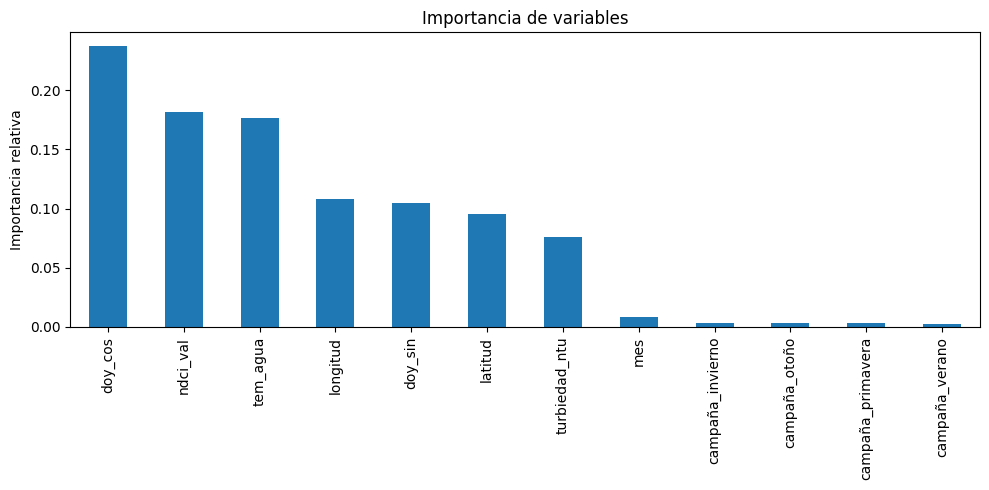

In [91]:
# ============================================
# Mostrar solo las variables más importantes
# ============================================

importancias = pd.Series(best.feature_importances_, index=X.columns)
importancias = importancias.sort_values(ascending=False)

print("\n Importancia de variables")
print(importancias)

# (Opcional) gráfico rápido
importancias.plot(kind="bar", figsize=(10,5), title="Importancia de variables")
plt.ylabel("Importancia relativa")
plt.tight_layout()
plt.show()


El gráfico muestra que las variables con mayor peso  fueron principalmente las asociadas a la estacionalidad del año y a las condiciones ambientales. La más influyente resultó ser la variable trigonométrica doy_cos (que captura la estacionalidad según el día del año), seguida de ndci_val (índice satelital) y tem_agua (temperatura del agua). En un nivel intermedio aparecen longitud, doy_sin y latitud, mientras que la turbiedad tuvo una importancia menor. Finalmente, variables como el mes y las campañas estacionales tuvieron un aporte casi nulo en la predicción.

### Exportar datos

In [92]:
# ========================
# LIBRERÍAS
# ========================
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm
import ee

# Asegúrate de haber inicializado GEE antes:
# ee.Authenticate()  # si es la 1ra vez
# ee.Initialize()

# ========================
# PARÁMETROS AJUSTABLES
# ========================
D = 7              # ventana temporal ±D días (3, 5, 7, 10...)
SCALE = 30         # escala (m) para reduceRegion (10, 20 o 30)
REDUCER = "mean"   # "mean", "median", "p25", "p75"
BUFFER_M = 0       # radio (m) alrededor del punto para promediar (0 = exacto)

# ========================
# CARGA + NORMALIZACIÓN CSV
# ========================
url = "https://raw.githubusercontent.com/MaricelSantos/Mentoria--Diplodatos-2025/main/Conexiones_Transparentes.csv"
df_raw = pd.read_csv(url)

# Asegurar fecha (dayfirst)
df_raw["fecha"] = pd.to_datetime(df_raw["fecha"], errors="coerce", dayfirst=True)

# Quedarnos con columnas clave y filtrar completos
df_coords = df_raw[["fecha", "latitud", "longitud"]].dropna().copy()

# Normalizar coordenadas: quitar separadores extra y convertir a float
def fix_coord(x):
    if pd.isna(x):
        return np.nan
    s = str(x).replace(" ", "").replace(",", ".")
    if s.count(".") > 1:
        first, *rest = s.split(".")
        s = first + "." + "".join(rest)
    try:
        return float(s)
    except:
        return np.nan

df_coords["latitud"]  = df_coords["latitud"].apply(fix_coord)
df_coords["longitud"] = df_coords["longitud"].apply(fix_coord)
df_coords = df_coords.dropna(subset=["fecha","latitud","longitud"]).copy()

# Ventanas temporales
df_coords["start"] = (df_coords["fecha"] - pd.Timedelta(days=D)).dt.strftime("%Y-%m-%d")
df_coords["end"]   = (df_coords["fecha"] + pd.Timedelta(days=D)).dt.strftime("%Y-%m-%d")

print(f"📌 Registros con fecha/lat/lon completos (tras normalizar): {len(df_coords)}")

# ========================
# FUNCIONES GEE
# ========================
def mask_s2_sr(image: ee.Image) -> ee.Image:
    """Máscara basada en SCL (Sentinel-2 L2A)."""
    scl = image.select("SCL")
    mask = (scl.neq(3)   # sombra
            .And(scl.neq(8))   # nubes
            .And(scl.neq(9))   # nubes altas
            .And(scl.neq(10))  # nubes finas
            .And(scl.neq(11))  # cirros
           )
    return image.updateMask(mask)

def add_ndci(image: ee.Image) -> ee.Image:
    """NDCI = (B5 - B4) / (B5 + B4)"""
    ndci = image.expression(
        "(b5 - b4) / (b5 + b4)",
        {"b5": image.select("B5"), "b4": image.select("B4")}
    ).rename("NDCI")
    return image.addBands(ndci)

def get_reducer():
    if REDUCER == "mean":
        return ee.Reducer.mean()
    elif REDUCER == "median":
        return ee.Reducer.median()
    elif REDUCER == "p25":
        return ee.Reducer.percentile([25])
    elif REDUCER == "p75":
        return ee.Reducer.percentile([75])
    return ee.Reducer.median()

S2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
      .map(mask_s2_sr)
      .map(add_ndci))

# ========================
# SUBIR PUNTOS A GEE
# ========================
def row_to_feature(row):
    geom = ee.Geometry.Point([float(row["longitud"]), float(row["latitud"])])
    return ee.Feature(geom, {
        "fecha": row["fecha"].strftime("%Y-%m-%d"),
        "start": str(row["start"]),
        "end":   str(row["end"])
    })

features = [row_to_feature(r) for _, r in df_coords.iterrows()]
fc = ee.FeatureCollection(features)

# ========================
# MUESTREO NDCI (SERVER-SIDE)
# ========================
def sample_ndci_per_feature(f: ee.Feature) -> ee.Feature:
    start = ee.Date(f.get("start"))
    end   = ee.Date(f.get("end"))
    geom  = f.geometry()
    col   = S2.filterDate(start, end).filterBounds(geom)
    n     = col.size()
    reducer = get_reducer()

    def when_has_scenes():
        img = col.median()  # o .sort("CLOUDY_PIXEL_PERCENTAGE").first()
        ndci_img = img.select("NDCI")
        geom_use = geom.buffer(BUFFER_M) if BUFFER_M > 0 else geom
        ndci_dict = ndci_img.unmask().reduceRegion(
            reducer   = reducer,
            geometry  = geom_use,
            scale     = SCALE,
            maxPixels = 1e8,
            bestEffort=True
        )
        ndci_val = ee.Dictionary(ndci_dict).values().get(0)
        return ee.Dictionary({"ndci_val": ndci_val, "n_scenes": n})

    def when_no_scenes():
        return ee.Dictionary({"ndci_val": None, "n_scenes": n})

    out = ee.Algorithms.If(n.gt(0), when_has_scenes(), when_no_scenes())
    return f.set(ee.Dictionary(out))

fc_out = fc.map(sample_ndci_per_feature)

# ========================
# BAJAR RESULTADOS A PANDAS (preservando TODOS)
# ========================
out = fc_out.getInfo()  # ~243 puntos: OK
rows = []
for feat in out["features"]:
    props = feat["properties"]
    lon, lat = feat["geometry"]["coordinates"]
    rows.append({
        "fecha": props.get("fecha"),
        "latitud":  lat,
        "longitud": lon,
        "ndci":     props.get("ndci_val"),
        "n_scenes": props.get("n_scenes"),
        "start":    props.get("start"),
        "end":      props.get("end"),
    })

df_ndci_all = pd.DataFrame(rows)
df_ndci_all["fecha"] = pd.to_datetime(df_ndci_all["fecha"], errors="coerce")
df_ndci_all["latitud"]  = pd.to_numeric(df_ndci_all["latitud"], errors="coerce")
df_ndci_all["longitud"] = pd.to_numeric(df_ndci_all["longitud"], errors="coerce")
df_ndci_all["ndci"]     = pd.to_numeric(df_ndci_all["ndci"], errors="coerce")
df_ndci_all["n_scenes"] = pd.to_numeric(df_ndci_all["n_scenes"], errors="coerce")

# Resultado FINAL: fecha, latitud, longitud, ndci (sin descartar nada)
df_ndci_final_243 = df_ndci_all.loc[:, ["fecha","latitud","longitud","ndci"]].copy()

print(f"\n✅ Entregadas filas: {len(df_ndci_final_243)} (deben ser tus 243). NDCI puede ser NaN si no hubo escenas en ±{D} días.")
print(df_ndci_final_243.head(10))

# (Opcional) guardar a CSV
df_ndci_final_243.to_csv("fecha_lat_lon_ndci_243.csv", index=False, encoding="utf-8")


📌 Registros con fecha/lat/lon completos (tras normalizar): 243

✅ Entregadas filas: 243 (deben ser tus 243). NDCI puede ser NaN si no hubo escenas en ±7 días.
       fecha    latitud   longitud      ndci
0 2021-02-24 -34.662789 -58.296669  0.000000
1 2021-05-19 -34.662789 -58.296669 -0.042972
2 2021-08-25 -34.662789 -58.296669  0.061825
3 2021-10-27 -34.662789 -58.296669  0.264581
4 2021-02-24 -34.630000 -58.328339  0.000000
5 2021-05-19 -34.630000 -58.328339 -0.037701
6 2021-08-25 -34.630000 -58.328339  0.022165
7 2021-10-27 -34.630000 -58.328339  0.045019
8 2021-02-24 -34.873061 -57.810561  0.093220
9 2021-05-19 -34.873061 -57.810561  0.069063


In [85]:
# ========================
# PROMEDIAR POR FECHA + COORDENADAS
# ========================
df_ndci_prom = (
    df_ndci_final_243
    .groupby(["fecha", "latitud", "longitud"], as_index=False)
    .agg({
        "ndci": "mean"
    })
)

print(f"\n✅ Dataset promediado: {len(df_ndci_prom)} registros únicos (fecha + lat/lon)")
print(df_ndci_prom.head(10))

# (Opcional) guardar
df_ndci_prom.to_csv("ndci_prom_por_fecha_latlon.csv", index=False, encoding="utf-8")



✅ Dataset promediado: 243 registros únicos (fecha + lat/lon)
       fecha    latitud   longitud      ndci
0 2021-02-24 -34.873061 -57.810561  0.093220
1 2021-02-24 -34.855808 -57.838144  0.183913
2 2021-02-24 -34.833911 -57.880211  0.057040
3 2021-02-24 -34.820711 -57.965319  0.150229
4 2021-02-24 -34.753000 -58.108281  0.078032
5 2021-02-24 -34.744169 -58.177231  0.266667
6 2021-02-24 -34.662789 -58.296669  0.000000
7 2021-02-24 -34.630000 -58.328339  0.000000
8 2021-02-24 -34.612761 -58.340611  0.000000
9 2021-02-24 -34.563231 -58.404119  0.000000


## Dataset FINAL

In [120]:
# ===============================
# 1) Dataset base con variables
# ===============================
df_ndci = df_ok.copy()

# Derivar 'año'
if "año" not in df_ndci.columns:
    df_ndci["año"] = df_ndci["fecha_dt"].dt.year
else:
    df_ndci["año"] = pd.to_numeric(df_ndci["año"], errors="coerce")
    df_ndci.loc[df_ndci["año"].isna() & df_ndci["fecha_dt"].notna(), "año"] = df_ndci["fecha_dt"].dt.year

# Normalizar campaña
if "campaña" not in df_ndci.columns:
    df_ndci["campaña"] = pd.NA
else:
    df_ndci["campaña"] = df_ndci["campaña"].astype("string").str.strip()

# Asegurar numéricos
for c in ["tem_agua", "turbiedad_ntu", "latitud", "longitud", "ndci_val"]:
    if c in df_ndci.columns:
        df_ndci[c] = pd.to_numeric(df_ndci[c], errors="coerce")

# Selección y orden
cols_finales = ["fecha_dt", "año", "campaña", "latitud", "longitud",
                "tem_agua", "turbiedad_ntu", "ndci_val"]
df_ndci_final = df_ndci[[c for c in cols_finales if c in df_ndci.columns]].copy()
df_ndci_final = df_ndci_final.rename(columns={"fecha_dt": "fecha"})

# Filtrar filas completas
req = ["fecha", "latitud", "longitud", "tem_agua", "turbiedad_ntu"]
df_ndci_final = df_ndci_final.dropna(subset=req).copy()

# Quedarse con NDCI no nulo
df_ndci_final = df_ndci_final[df_ndci_final["ndci_val"].notna()].copy()
print(f"✅ Filas con NDCI no nulo: {len(df_ndci_final)}")

# ===============================
# 2) Promediar NDCI por fecha/lat/lon
# ===============================
df_ndci_prom = (
    df_ndci_final
    .groupby(["fecha", "latitud", "longitud"], as_index=False)
    .agg(ndci=("ndci_val", "mean"))
)

print(f"✅ Dataset promediado: {len(df_ndci_prom)} registros únicos (fecha + lat/lon)")

# ===============================
# 3) Unir variables base con NDCI promedio
# ===============================
df_unido = pd.merge(
    df_ndci_final.drop(columns=["ndci_val"]),  # sin el NDCI original
    df_ndci_prom,
    on=["fecha", "latitud", "longitud"],
    how="inner"
)

# Forzar año a entero
df_unido["año"] = df_unido["año"].astype("Int64")

print(f"✅ Dataset final unificado: {len(df_unido)} registros")
print(df_unido.head(10))

# (Opcional) guardar
df_unido.to_csv("ndci_variables_unido.csv", index=False, encoding="utf-8")

# Descargar a tu PC
from google.colab import files
files.download("ndci_variables_unido.csv")

✅ Filas con NDCI no nulo: 184
✅ Dataset promediado: 184 registros únicos (fecha + lat/lon)
✅ Dataset final unificado: 184 registros
       fecha   año    campaña    latitud   longitud  tem_agua  turbiedad_ntu  \
0 2021-05-19  2021      otoño -34.662789 -58.296669      16.7           30.0   
1 2021-08-25  2021   invierno -34.662789 -58.296669      14.7           21.0   
2 2021-10-27  2021  primavera -34.662789 -58.296669      26.0           10.0   
3 2021-05-19  2021      otoño -34.630000 -58.328339      16.8           36.0   
4 2021-08-25  2021   invierno -34.630000 -58.328339      15.4           22.0   
5 2021-10-27  2021  primavera -34.630000 -58.328339      21.4           14.0   
6 2021-02-24  2021     verano -34.873061 -57.810561      20.0           18.0   
7 2021-08-25  2021   invierno -34.873061 -57.810561      10.0            8.7   
8 2021-10-27  2021  primavera -34.873061 -57.810561      11.0            4.9   
9 2021-02-24  2021     verano -34.855808 -57.838144      21.0       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [112]:
print(df.columns)


Index(['clorofila_a_ug_l', 'campaña', 'año', 'fecha_norm', 'latitud',
       'longitud'],
      dtype='object')


In [95]:
print(df_ndci_prom["fecha"].nunique())   # cuántas fechas distintas
print(df_ndci_prom["fecha"].value_counts().head(10))  # cuántos puntos por fecha


13
fecha
2021-10-27    18
2022-05-04    18
2021-08-25    17
2023-05-10    17
2022-10-31    16
2023-02-22    15
2023-11-14    14
2022-02-23    14
2021-02-24    13
2021-05-19    13
Name: count, dtype: int64


#### Mapa de distribucion de puntos

In [97]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# ===============================
# Crear mapa base en Google Satellite
# ===============================
m = folium.Map(location=[df_unido["latitud"].mean(), df_unido["longitud"].mean()],
               zoom_start=10, tiles=None)

folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attr="Google Satellite",
    name="Google Satellite"
).add_to(m)

# ===============================
# Colores distintos por cada fecha
# ===============================
fechas_unicas = sorted(df_unido["fecha"].unique())
cmap = cm.get_cmap("tab20", len(fechas_unicas))
colores = {fecha: mcolors.rgb2hex(cmap(i)) for i, fecha in enumerate(fechas_unicas)}

# ===============================
# Una capa por cada fecha
# ===============================
for fecha, grupo in df_unido.groupby("fecha"):
    color_fecha = colores[fecha]
    capa = folium.FeatureGroup(name=str(fecha.date()), show=False)

    for _, row in grupo.iterrows():
        popup_html = (
            f"<b>Fecha:</b> {row['fecha'].date()}<br>"
            f"<b>Año:</b> {row['año']}<br>"
            f"<b>Campaña:</b> {row['campaña']}<br>"
            f"<b>Temp. agua:</b> {row['tem_agua']} °C<br>"
            f"<b>Turbiedad:</b> {row['turbiedad_ntu']} NTU<br>"
            f"<b>NDCI:</b> {row['ndci']:.3f}"
        )

        folium.CircleMarker(
            location=[row["latitud"], row["longitud"]],
            radius=6,
            color=color_fecha,
            fill=True,
            fill_opacity=0.9,
            popup=popup_html
        ).add_to(capa)

    capa.add_to(m)

# Control de capas
folium.LayerControl(collapsed=False).add_to(m)

m


/tmp/ipython-input-1148602775.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(fechas_unicas))


El resultado final corresponde a un mapa que integra la localización geográfica de los puntos de muestreo obtenidos en campo, acompañados de las variables medidas in situ y del índice satelital NDCI. La visualización permite identificar las variaciones espaciales y temporales en la ubicación de las tomas de muestra, diferenciadas según el año y la fecha de relevamiento.
Un total de 184 datos validos.

# FORMULA DEL ICA

El Índice de Calidad de Agua utilizado se construye a partir de una versión adaptada de la fórmula clásica del ICA-NSF (desarrollado en Estados Unidos en la década de 1970 por la National Sanitation Foundation). En lugar de emplear las nueve variables originales, se trabaja con tres parámetros disponibles en el estudio: NDCI como proxy de clorofila-a, turbidez en NTU y temperatura del agua en grados Celsius. Cada uno de estos parámetros se transforma primero en un subíndice con valores entre 0 y 100, donde 100 representa la mejor calidad posible y 0 la peor, siguiendo curvas pieza a pieza inspiradas en los criterios del NSF.

En el caso del NDCI, valores bajos y cercanos a cero o negativos se consideran indicativos de buena calidad del agua, porque reflejan baja concentración de clorofila, y por lo tanto reciben puntuaciones altas. A medida que el NDCI aumenta hacia 0.6 o 1.0, los valores del subíndice descienden hasta llegar a cero, reflejando condiciones de eutrofización y mala calidad. La turbidez sigue un criterio similar: aguas claras con menos de 5 NTU alcanzan puntuaciones casi perfectas, mientras que valores por encima de 250–500 NTU reducen el subíndice a niveles muy bajos. La temperatura, en cambio, se modela con un óptimo alrededor de los 20 °C, donde se asigna la máxima puntuación, y cada grado de desviación reduce el valor en cuatro puntos, de modo que tanto aguas muy frías como muy cálidas penalizan la calidad.

Una vez obtenidos los tres subíndices, el ICA se calcula como un promedio ponderado. En esta adaptación se asignó un peso del 50 % al NDCI por su carácter crítico como indicador de eutrofización, un 30 % a la turbidez como medida del estado físico del agua y un 20 % a la temperatura como variable de soporte. Si algún dato falta, los pesos de las variables restantes se renormalizan para no perder el registro.

El resultado final se clasifica cualitativamente siguiendo la escala de aptitud para uso recreativo con contacto directo. Los valores de 95 a 100 se consideran aptos, los de 80 a 94 levemente deteriorados, los de 65 a 79 deteriorados, los de 45 a 64 muy deteriorados y los de 0 a 44 extremadamente deteriorados. Esta clasificación aproxima la aptitud del agua para actividades recreativas y permite una interpretación espacial y temporal clara de las condiciones del recurso.

Este esquema se eligió porque preserva la lógica del ICA-NSF original, pero adaptado a la disponibilidad de datos del estudio y armonizado con una escala de referencia utilizada en contextos locales de evaluación ambiental.

In [121]:

df = df_unido.copy()

# ================================
# Helpers
# ================================
def _interp_clip(x, xp, fp):
    val = np.interp(x, xp, fp, left=fp[0], right=fp[-1])
    return np.clip(val, 0, 100)

# ================================
# Subíndices (0–100)
# ================================

# 1) NDCI como proxy de clorofila (valores altos = peor)
# Ajustá los umbrales a tu rango real de NDCI
_chl_x = np.array([-0.2, 0.0, 0.1, 0.2, 0.4, 0.6, 1.0], dtype=float)
_chl_y = np.array([100, 90, 70, 50, 30, 10, 0], dtype=float)

def I_ndci(x):
    return _interp_clip(x, _chl_x, _chl_y)

# 2) Turbidez (NTU)
_tur_x = np.array([0, 5, 25, 50, 100, 250, 500], dtype=float)
_tur_y = np.array([100, 95, 80, 60, 35, 10, 0], dtype=float)

def I_turbidez(x):
    return _interp_clip(x, _tur_x, _tur_y)

# 3) Temperatura (°C), óptimo ~20
def I_temperatura(T):
    if pd.isna(T):
        return np.nan
    score = 100 - 4.0 * abs(T - 20.0)
    return float(np.clip(score, 0, 100))

# ================================
# Calcular subíndices y ICA
# ================================
W_NDCI, W_TURB, W_TEMP = 0.50, 0.30, 0.20

df["I_ndci"] = df["ndci"].apply(I_ndci)
df["I_turbidez"] = df["turbiedad_ntu"].apply(I_turbidez)
df["I_temp"] = df["tem_agua"].apply(I_temperatura)

def calc_ica(row):
    vals, weights = [], []
    for v, w in [(row["I_ndci"], W_NDCI),
                 (row["I_turbidez"], W_TURB),
                 (row["I_temp"], W_TEMP)]:
        if pd.notna(v):
            vals.append(v); weights.append(w)
    if not vals:
        return np.nan
    wsum = sum(weights)
    weights = [w/wsum for w in weights]
    return float(np.dot(vals, weights))

df["ICA_adaptado"] = df.apply(calc_ica, axis=1)

# ================================
# Clasificación cualitativa adaptada
# ================================
def clasificar(v):
    if pd.isna(v):
        return "Sin dato"
    elif v >= 95:
        return "Apta"
    elif v >= 80:
        return "Levemente deteriorada"
    elif v >= 65:
        return "Deteriorada"
    elif v >= 45:
        return "Muy deteriorada"
    else:
        return "Extremadamente deteriorada"

df["ICA_clase"] = df["ICA_adaptado"].apply(clasificar)

# ================================
# Resultados
# ================================
print("✅ ICA adaptado calculado con nueva escala")
print(df[["fecha","ndci","turbiedad_ntu","tem_agua",
          "I_ndci","I_turbidez","I_temp",
          "ICA_adaptado","ICA_clase"]].head(10))



✅ ICA adaptado calculado con nueva escala
       fecha      ndci  turbiedad_ntu  tem_agua     I_ndci  I_turbidez  \
0 2021-05-19 -0.044364           30.0      16.7  92.218182      76.000   
1 2021-08-25  0.063536           21.0      14.7  77.292818      83.000   
2 2021-10-27  0.249029           10.0      26.0  45.097108      91.250   
3 2021-05-19 -0.043414           36.0      16.8  92.170686      71.200   
4 2021-08-25  0.024405           22.0      15.4  85.118975      82.250   
5 2021-10-27  0.049751           14.0      21.4  80.049751      88.250   
6 2021-02-24  0.221327           18.0      20.0  47.867328      85.250   
7 2021-08-25  0.147297            8.7      10.0  60.540541      92.225   
8 2021-10-27  0.113356            4.9      11.0  67.328844      95.100   
9 2021-02-24  0.255914           16.0      21.0  44.408602      86.750   

   I_temp  ICA_adaptado              ICA_clase  
0    86.8     86.269091  Levemente deteriorada  
1    78.8     79.306409            Deteriorad

## Mapa

In [127]:
# ================================
# 0) Copiar dataset base
# ================================
df = df_unido.copy()

# ================================
# Helpers
# ================================
def _interp_clip(x, xp, fp):
    """Interpolación lineal y recorte 0–100"""
    val = np.interp(x, xp, fp, left=fp[0], right=fp[-1])
    return np.clip(val, 0, 100)

# ================================
# Subíndices (0–100)
# ================================

# 1) NDCI como proxy de clorofila
_chl_x = np.array([-0.2, 0.0, 0.1, 0.2, 0.4, 0.6, 1.0], dtype=float)
_chl_y = np.array([100, 90, 70, 50, 30, 10, 0], dtype=float)
def I_ndci(x):
    return _interp_clip(x, _chl_x, _chl_y)

# 2) Turbidez (NTU)
_tur_x = np.array([0, 5, 25, 50, 100, 250, 500], dtype=float)
_tur_y = np.array([100, 95, 80, 60, 35, 10, 0], dtype=float)
def I_turbidez(x):
    return _interp_clip(x, _tur_x, _tur_y)

# 3) Temperatura (°C), óptimo ~20
def I_temperatura(T):
    if pd.isna(T):
        return np.nan
    score = 100 - 4.0 * abs(T - 20.0)
    return float(np.clip(score, 0, 100))

# ================================
# Calcular subíndices y ICA
# ================================
W_NDCI, W_TURB, W_TEMP = 0.50, 0.30, 0.20

df["I_ndci"] = df["ndci"].apply(I_ndci)
df["I_turbidez"] = df["turbiedad_ntu"].apply(I_turbidez)
df["I_temp"] = df["tem_agua"].apply(I_temperatura)

def calc_ica(row):
    vals, weights = [], []
    for v, w in [(row["I_ndci"], W_NDCI),
                 (row["I_turbidez"], W_TURB),
                 (row["I_temp"], W_TEMP)]:
        if pd.notna(v):
            vals.append(v); weights.append(w)
    if not vals:
        return np.nan
    wsum = sum(weights)
    weights = [w/wsum for w in weights]
    return float(np.dot(vals, weights))

df["ICA_adaptado"] = df.apply(calc_ica, axis=1)

# ================================
# Clasificación cualitativa
# ================================
def clasificar(v):
    if pd.isna(v):
        return "Sin dato"
    elif v >= 95:
        return "Apta"
    elif v >= 80:
        return "Levemente deteriorada"
    elif v >= 65:
        return "Deteriorada"
    elif v >= 45:
        return "Muy deteriorada"
    else:
        return "Extremadamente deteriorada"

df["ICA_clase"] = df["ICA_adaptado"].apply(clasificar)

print("✅ ICA adaptado calculado con nueva escala")
print(df[["fecha","ndci","turbiedad_ntu","tem_agua",
          "I_ndci","I_turbidez","I_temp",
          "ICA_adaptado","ICA_clase"]].head(10))

# ================================
# 1) Crear mapa base
# ================================
lat_c = df["latitud"].mean()
lon_c = df["longitud"].mean()
m = folium.Map(location=[lat_c, lon_c], zoom_start=9, tiles=None)

# Capas base
folium.TileLayer("CartoDB positron", name="CartoDB Positron").add_to(m)
folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attr="Google Satellite",
    name="Google Satellite",
    overlay=False,
    control=True
).add_to(m)

# ================================
# 2) Colores por clase ICA
# ================================
color_map = {
    "Apta": "#2ECC71",                     # verde
    "Levemente deteriorada": "#F4D03F",    # amarillo
    "Deteriorada": "#E67E22",              # naranja
    "Muy deteriorada": "#E74C3C",          # rojo
    "Extremadamente deteriorada": "#6C3483", # violeta
    "Sin dato": "#95A5A6"                  # gris
}

# ================================
# 3) Puntos de monitoreo por año
# ================================
for año in sorted(df["año"].dropna().unique()):
    capa = folium.FeatureGroup(name=f"Puntos ICA {año}", show=(año==2021))  # mostrar 2021 por defecto
    df_año = df[df["año"] == año].dropna(subset=["latitud","longitud"])

    for _, r in df_año.iterrows():
        folium.CircleMarker(
            [float(r["latitud"]), float(r["longitud"])],
            radius=6,
            color=color_map.get(r["ICA_clase"], "#666"),
            fill=True,
            fill_opacity=0.9,
            popup=folium.Popup(
                f"<b>Año:</b> {r['año']}<br>"
                f"<b>Fecha:</b> {r['fecha'].date()}<br>"
                f"<b>ICA:</b> {r['ICA_adaptado']:.1f} ({r['ICA_clase']})<br>"
                f"<b>NDCI:</b> {r['ndci']:.3f}<br>"
                f"<b>Turbidez:</b> {r['turbiedad_ntu']} NTU<br>"
                f"<b>Temperatura:</b> {r['tem_agua']} °C",
                max_width=300
            )
        ).add_to(capa)

    capa.add_to(m)


# ================================
# 4) Leyenda fija
# ================================
legend_html = """
<div style="
position: fixed;
bottom: 40px; left: 40px; width: 230px; height: 210px;
background-color: white;
border:2px solid grey; z-index:9999; font-size:14px;
padding: 10px;
">
<b>ICA Adaptado</b><br>
<i style="background:#2ECC71;width:18px;height:18px;float:left;margin-right:8px;"></i>Apta (95–100)<br>
<i style="background:#F4D03F;width:18px;height:18px;float:left;margin-right:8px;"></i>Levemente deteriorada (80–94)<br>
<i style="background:#E67E22;width:18px;height:18px;float:left;margin-right:8px;"></i>Deteriorada (65–79)<br>
<i style="background:#E74C3C;width:18px;height:18px;float:left;margin-right:8px;"></i>Muy deteriorada (45–64)<br>
<i style="background:#6C3483;width:18px;height:18px;float:left;margin-right:8px;"></i>Extremadamente deteriorada (0–44)<br>
<i style="background:#95A5A6;width:18px;height:18px;float:left;margin-right:8px;"></i>Sin dato<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# ================================
# 5) Control de capas y mostrar
# ================================
folium.LayerControl(collapsed=False).add_to(m)
m

✅ ICA adaptado calculado con nueva escala
       fecha      ndci  turbiedad_ntu  tem_agua     I_ndci  I_turbidez  \
0 2021-05-19 -0.044364           30.0      16.7  92.218182      76.000   
1 2021-08-25  0.063536           21.0      14.7  77.292818      83.000   
2 2021-10-27  0.249029           10.0      26.0  45.097108      91.250   
3 2021-05-19 -0.043414           36.0      16.8  92.170686      71.200   
4 2021-08-25  0.024405           22.0      15.4  85.118975      82.250   
5 2021-10-27  0.049751           14.0      21.4  80.049751      88.250   
6 2021-02-24  0.221327           18.0      20.0  47.867328      85.250   
7 2021-08-25  0.147297            8.7      10.0  60.540541      92.225   
8 2021-10-27  0.113356            4.9      11.0  67.328844      95.100   
9 2021-02-24  0.255914           16.0      21.0  44.408602      86.750   

   I_temp  ICA_adaptado              ICA_clase  
0    86.8     86.269091  Levemente deteriorada  
1    78.8     79.306409            Deteriorad

El mapa muestra la distribución espacial del Índice de Calidad de Agua adaptado en la franja costera del Río de la Plata. Los puntos de monitoreo están representados con colores que corresponden a la escala de aptitud para uso recreativo con contacto directo. Se observa que:
- Año 2021: Los puntos de monitoreo se concentran principalmente en la franja costera central y norte. La mayoría se clasifica como Levemente deteriorada (amarillo) y Deteriorada (naranja), con algunos casos aislados de Muy deteriorada (rojo). No aparecen sitios clasificados como Apta, lo que indica que ya desde el primer año hay signos de presión ambiental sobre la calidad del agua.
- Año 2022: Se observa una mayor dispersión espacial de los puntos. Predominan las categorías Levemente deteriorada y Deteriorada, con un aumento de tramos clasificados como Muy deteriorada hacia el sur. La tendencia muestra un deterioro más marcado que en 2021, lo cual sugiere que las condiciones ambientales o de carga de nutrientes empeoraron respecto al año anterior.
- Año 2023: En este año se refuerza la tendencia negativa: gran parte de la costa presenta categorías Deteriorada y Muy deteriorada, extendiéndose de manera continua a lo largo de la línea de monitoreo. Aun así, persisten tramos en amarillo (Levemente deteriorada), especialmente hacia el norte, lo que refleja cierta heterogeneidad espacial. No se registran zonas Aptas, lo que confirma un escenario de mayor compromiso ambiental.
- Año 2024: Aunque hay menos puntos muestreados (9 en total), los que aparecen muestran una combinación entre Levemente deteriorada y Deteriorada, con presencia puntual de Muy deteriorada. El patrón sugiere que la tendencia crítica de 2023 continúa, aunque la menor cantidad de datos limita la posibilidad de conclusiones sólidas para este año.

# Conclusión

En este trabajo se demuestra que no todas las variables medidas en una estación de monitoreo tienen la misma relevancia para evaluar la calidad del agua. Si bien todas aportan información, la clorofila-a se destaca como uno de los indicadores más importantes, ya que refleja directamente los procesos de eutrofización y el estado ecológico del sistema. En contraste, parámetros como la turbidez y la temperatura cumplen un rol complementario, aportando contexto a la interpretación de los resultados.

El índice de calidad de agua aplicado, adaptado a los datos disponibles, logra representar de manera razonable los parámetros críticos medidos en las estaciones. Sin embargo, presenta la limitación de considerar menos variables que el ICA-NSF original. Aun así, se observan tendencias claras: la calidad del agua está fuertemente condicionada por la estacionalidad, con valores muy bajos de clorofila en 2021 y aumentos significativos en los años siguientes, sobre todo durante el invierno y la primavera.

Aunque este conjunto de datos no incluye información poblacional, resulta evidente que la presión demográfica y antrópica en las áreas costeras del Río de la Plata se relaciona indirectamente con la calidad del agua, al influir en las cargas de nutrientes y en la generación de condiciones menos favorables.

Todavía queda mucho por analizar y probar. Se requiere tiempo y dedicación para un estudio más profundo que incorpore nuevas variables y técnicas. No obstante, el tema resulta sumamente interesante y abre un campo de investigación prometedor, tanto para el ámbito académico como para la gestión ambiental.

En definitiva, la calidad del análisis depende directamente de la calidad de la información de base.